# **Extended Project 3: Unsurpervised Learning**

Course: Computation Machine Learning I

Submitted: Dec 19, 2021

Student: Mathias Schindler

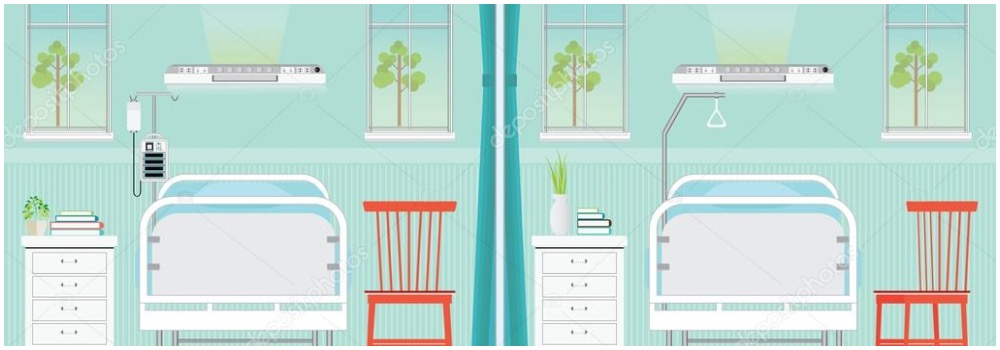

# 0.0 Instructions

## 0.0.1 Description

In this project, you have to cluster patients that enter an ICU (Intensive Care Unit) by the features that are known on the very first day. At the end, we will check if these groups of patients have similar outcome results, in terms of length of stay or probability of death.

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_unsupervised_features.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Most columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*. 



Note that the main cause/disease of patient contidition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

Additionally, the file *mimic_unsupervised_response.csv* contains the outcome of the patients visit to the ICU, did they die and how many days were they in the ICU for. We will use this to evaluate the clusters we produce.


Main tasks are:
+ Using *mimic_unsupervised_features.csv* file to cluster patient stays .
+ Using *mimic_unsupervised_response.csv*, check if resulting clusters are related to outcomes of patients, such as length of stay, mortality or assigned ICU.

## 0.0.2 Instructions

You can follow these **steps** for your implementation:
1. *Explore* and understand the dataset. 
2. For your *first* implmentation

   i). ~~Remove all non numeric columns (e.g ID's, dates and categories)~~<br />
   ii). ~~Standardise the data to have 0 column means and variance 1~~<br />
   iii). ~~Cluster the data using K-means. Show how you decided how many clusters to use~~<br />
   or<br />
   Cluster the data using spectral clustering. Show how you decided how many clusters to use<br />
3. ~~Then use the single valued decomposition (SVD) to reduce the dimensionality of the numerical feature space. Show how you decided how many dimensions to use. See how this affects your clustering~~<br />

4. Manage the date variables e.g. try to create an Age variable, ~~and manage categorial features e.g. create *dummy variables* for relevant categorical features.  See how this affects your clustering~~

5. Consider how to incorporate the comorbidity information.

6. ~~Explore relationship between clusters and outcomes of patients~~

Feel free to reduce the dataset if you experience computational constraints.
As a *bonus*, explore if adding as an input feature the cluster label would improve a prediction model of mortality (e.g. try with LogisticRegression, or any non-linear model of your choice).

## 0.0.3 Grading Criteria

*weights for In-Class*
+ Code runs - 20%
+ ~~Data preparation - 20%~~
+ ~~Clustering algorithm used - 25%~~
+ ~~Reasonable selection of number of clusters demonstrated - 25%~~
+ ~~SVD used - 5%~~
+ ~~Reasonable selection of number of dimensions - 5%~~
+ ~~Good exploration of relation between clusters and patient outcomes - 0%~~
+ ~~Neat and understandable code, with some titles and comments - 0%~~
+ Improved methods from what we discussed in class (properly explained/justified) - 0%

# **0.1 Preamble**

In [620]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [621]:
# Set path
import os
os.chdir('/content/drive/My Drive/CML1_Projects/Project3_Unsupervised')

In [642]:
# Install 'sklearn_extra'
!pip install scikit-learn-extra
!pip install gap-stat
!pip install impyute

In [636]:
# Import libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from datetime import datetime, timedelta
from gap_statistic import OptimalK
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression, LinearRegression

In [624]:
import MSchindler_project3_functions as my_fcts
dir(my_fcts)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'make_feat_importance_plot',
 'make_multi_point_pred',
 'make_roc_plot',
 'make_scree_plot',
 'np',
 'pd',
 'plot_confusion_matrix',
 'plt',
 'reweight',
 'reweight_proba_multi',
 'sns']

# **1. EDA**

Exploratory Data Analysis

## 1.1 Load Data

In [625]:
# Load data w features and responses
feats = pd.read_csv("Data/mimic_unsupervised_features.csv", index_col=1)
target = pd.read_csv("Data/mimic_unsupervised_response.csv", index_col=1)

In [626]:
# Remove first three columns (identifiers)
feats = feats.drop(feats.columns[0:3], axis=1)
target = target.drop(target.columns[0:3], axis=1)

## 1.2 Data Types

In [627]:
# Check which variables are neither int or float and drop
print(feats.dtypes)

HeartRate_Min     float64
HeartRate_Max     float64
HeartRate_Mean    float64
SysBP_Min         float64
SysBP_Max         float64
SysBP_Mean        float64
DiasBP_Min        float64
DiasBP_Max        float64
DiasBP_Mean       float64
MeanBP_Min        float64
MeanBP_Max        float64
MeanBP_Mean       float64
RespRate_Min      float64
RespRate_Max      float64
RespRate_Mean     float64
TempC_Min         float64
TempC_Max         float64
TempC_Mean        float64
SpO2_Min          float64
SpO2_Max          float64
SpO2_Mean         float64
Glucose_Min       float64
Glucose_Max       float64
Glucose_Mean      float64
GENDER             object
DOB                object
ADMITTIME          object
Diff              float64
ADMISSION_TYPE     object
INSURANCE          object
RELIGION           object
MARITAL_STATUS     object
ETHNICITY          object
DIAGNOSIS          object
ICD9_diagnosis     object
FIRST_CAREUNIT     object
dtype: object


## 1.3 Missing Data

In [628]:
# Chechk for NaNs
print(feats.isnull().any())

HeartRate_Min     False
HeartRate_Max     False
HeartRate_Mean    False
SysBP_Min         False
SysBP_Max         False
SysBP_Mean        False
DiasBP_Min        False
DiasBP_Max        False
DiasBP_Mean       False
MeanBP_Min        False
MeanBP_Max        False
MeanBP_Mean       False
RespRate_Min      False
RespRate_Max      False
RespRate_Mean     False
TempC_Min         False
TempC_Max         False
TempC_Mean        False
SpO2_Min          False
SpO2_Max          False
SpO2_Mean         False
Glucose_Min       False
Glucose_Max       False
Glucose_Mean      False
GENDER            False
DOB               False
ADMITTIME         False
Diff              False
ADMISSION_TYPE    False
INSURANCE         False
RELIGION          False
MARITAL_STATUS    False
ETHNICITY         False
DIAGNOSIS         False
ICD9_diagnosis    False
FIRST_CAREUNIT    False
dtype: bool


## 1.4 Outlier Detection

# **2. Preprocessing Data**

## 2.0 Feature Engineering

### 2.0.1 Age-at-Admission Variable

Format admission datetime

In [629]:
%%capture
# Add empty column for admittime
NaN = np.nan
feats['real_admittime'] = NaN

# Realistic admittime formatting
for i in range(len(feats)):
  admit_datetime = datetime.strptime(feats['ADMITTIME'].iloc[i], '%Y-%m-%d %H:%M:%S')
  delta = timedelta(days = feats['Diff'].iloc[i])
  real_admit = admit_datetime + delta
  feats['real_admittime'].iloc[i] = real_admit

Format date of birth datetime

In [630]:
%%capture
# Add empty column for date of birth
NaN = np.nan
feats['real_dob'] = NaN

# Realistic date of birth formatting
for i in range(len(feats)):
  dob_datetime = datetime.strptime(feats['DOB'].iloc[i], '%Y-%m-%d %H:%M:%S')
  delta = timedelta(days = feats['Diff'].iloc[i])
  real_dob = dob_datetime + delta
  feats['real_dob'].iloc[i] = real_dob

Age-at-Admission is the difference between date of admission and date of birth:

In [631]:
# Drop previous datetime variables
feats = feats.drop(['ADMITTIME', 'DOB'], axis = 1)
feats

# Add empty column for age at admission
NaN = np.nan
feats['age_at_admin'] = NaN

# Subtract admintime and dob:
for i in range(len(feats)):
  feats['age_at_admin'].iloc[i] = feats['real_admittime'].iloc[i] - feats['real_dob'].iloc[i]
  feats['age_at_admin'].iloc[i] = feats['age_at_admin'].iloc[i].days / 365.25

# Drop old admintime and dob variables
feats = feats.drop(['real_admittime', 'real_dob', 'Diff'], axis = 1)
feats

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,age_at_admin
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
55440,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,94.0,74.543478,15.0,30.0,22.347826,35.111111,36.944444,36.080247,90.0,99.0,95.739130,111.0,230.0,160.777778,F,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,69.5606
76908,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,84.0,74.800000,13.0,21.0,16.058824,36.333333,36.611111,36.472222,98.0,100.0,99.058824,103.0,103.0,103.000000,F,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,42.0726
95798,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,88.0,72.888889,13.0,21.0,15.900000,36.444444,36.888889,36.666667,100.0,100.0,100.000000,132.0,346.0,217.636364,F,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,68.1643
40708,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,94.0,62.783784,12.0,35.0,26.771429,36.333333,39.500000,37.833333,78.0,100.0,95.085714,108.0,139.0,125.000000,F,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,74.9103
63311,70.0,130.0,97.951220,107.0,155.0,128.414634,60.0,88.0,74.780488,72.0,100.0,86.820513,10.0,23.0,15.707317,36.000000,36.944444,36.591270,96.0,100.0,98.878049,92.0,142.0,104.400000,M,EMERGENCY,Private,CATHOLIC,SINGLE,WHITE,LARGE GASTOINTESTINAL BLEED,5550,MICU,49.1718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28043,65.0,92.0,78.500000,60.0,160.0,110.976190,34.0,94.0,56.595238,41.0,102.0,69.285714,10.0,23.0,15.420000,35.555556,36.611111,36.155556,97.0,100.0,99.833333,68.0,139.0,103.571429,M,EMERGENCY,Medicare,CATHOLIC,MARRIED,WHITE,ALTERED MENTAL STATUS,3229,MICU,87.5017
87605,74.0,112.0,89.156250,100.0,150.0,123.272727,58.0,83.0,67.818182,74.0,99.0,82.363636,9.0,24.0,14.781250,37.055556,37.777778,37.476190,95.0,100.0,97.531250,184.0,377.0,245.400000,M,EMERGENCY,Private,NOT SPECIFIED,MARRIED,BLACK/HAITIAN,NEW BRAIN MASS,1918,SICU,65.8563
47492,58.0,97.0,76.933333,94.0,131.0,112.037037,55.0,83.0,67.370370,66.0,95.0,78.500000,14.0,27.0,18.166667,36.055556,37.277778,37.007937,97.0,100.0,99.200000,51.0,460.0,190.000000,F,EMERGENCY,Private,PROTESTANT QUAKER,DIVORCED,BLACK/AFRICAN AMERICAN,HYPOGLYCEMIA,24980,MICU,62.8884


**Inspection of created age variable**

In [633]:
feats['age_at_admin'].isnull().any()

False

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


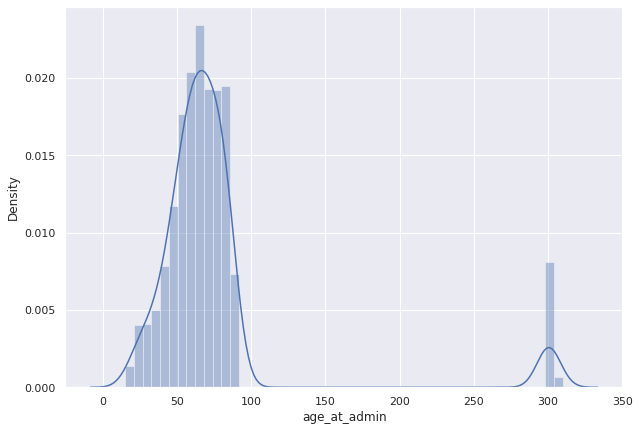

In [641]:
sns.set(rc = {'figure.figsize':(10,7)})
sns.distplot(feats['age_at_admin'])

In [ ]:
#Count of 
print("No. of individuals more than 100 years old: " + str(feats[feats['age_at_admin'] > 100]['age_at_admin'].count()))
print("\n Value counts for those >100 years:")
print(feats[feats['age_at_admin'] > 100]['age_at_admin'].value_counts() )

No. of individuals more than 100 years old: 903

 Value counts for those >100 years:
299.994524    633
300.054757      4
306.877481      3
300.021903      3
301.648186      3
             ... 
305.114305      1
304.290212      1
303.085558      1
302.743326      1
303.071869      1
Name: age_at_admin, Length: 237, dtype: int64


So, for those over 100 years old they are 299 years old. Seems quite unrealistic. In order to not delete observations (and for a lack of better alternative) these values are replaced by the median.

In [653]:
median = feats.loc[feats['age_at_admin']<100, 'age_at_admin'].median()
feats.loc[feats.age_at_admin >= 100, 'age_at_admin'] = np.nan
feats.fillna(median, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


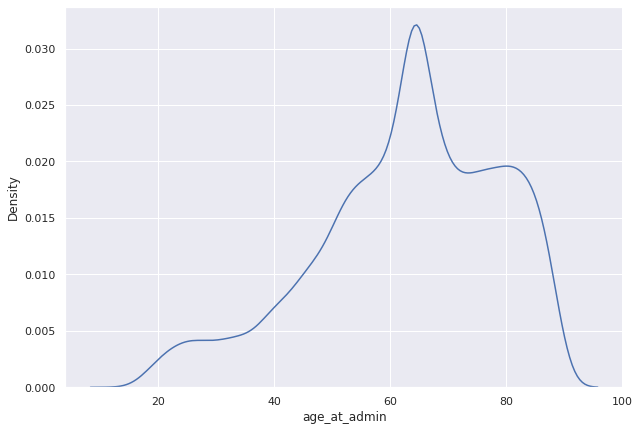

In [656]:
sns.set(rc = {'figure.figsize':(10,7)})
sns.distplot(feats['age_at_admin'], hist = False)

## 2.0 Split Train and Test Data

In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.33, random_state=42)

## 2.0 Split Categorical and Numerical Data

In [ ]:
# Numerical Data
cat_feat_lst = ["GENDER", "ADMISSION_TYPE", "INSURANCE", "RELIGION", "MARITAL_STATUS", "ETHNICITY", "DIAGNOSIS", "ICD9_diagnosis", "FIRST_CAREUNIT"]

X_train_num = X_train.drop(cat_feat_lst, axis = 1)
X_test_num = X_test.drop(cat_feat_lst, axis = 1)

In [ ]:
# Categorical Data
X_train_cat = X_train[cat_feat_lst]
X_test_cat = X_test[cat_feat_lst]

## 2.1 Numerical Features 

### 2.1.1 Standardization

Data will be standardized with mean zero and unit variance. This such that distance measures are in comparable units.

In [ ]:
# Instantiate scaler
scaler = preprocessing.StandardScaler()

# Fit to data
scaler.fit(X_train_num)

# Transform data
X_train_scl = scaler.transform(X_train_num)
X_test_scl = scaler.transform(X_test_num)

# Format data
X_train_scl = pd.DataFrame(X_train_scl, columns = X_train_num.columns, index = X_train_num.index)
X_test_scl = pd.DataFrame(X_test_scl, columns = X_test_num.columns, index = X_test_num.index)

## 2.2 Categorical Features

### 2.2.1 One-Hot Encoding

Inspecting for which features it would be feasible to construct dummy variables.<br>
Features `GENDER`, `ADMISSION_TYPE`, `INSURANCE` and `FIRST_CAREUNIT` are chosen for one-hot encoding. These seem relevant for the later task of predicting mortality and length of stay, while having a not-too-large number of categories (so dimensionality does not explode).

In [ ]:
for c in cat_feat_lst:
  print(c)
  print(X_train_cat[c].value_counts() )
  print("\n\n")

GENDER
M    6637
F    5071
Name: GENDER, dtype: int64



ADMISSION_TYPE
EMERGENCY    10001
ELECTIVE      1574
URGENT         133
Name: ADMISSION_TYPE, dtype: int64



INSURANCE
Medicare      6593
Private       3485
Medicaid      1209
Government     340
Self Pay        81
Name: INSURANCE, dtype: int64



RELIGION
CATHOLIC                  4413
NOT SPECIFIED             3109
PROTESTANT QUAKER         1505
JEWISH                    1023
UNOBTAINABLE               682
OTHER                      375
EPISCOPALIAN               175
GREEK ORTHODOX             104
CHRISTIAN SCIENTIST         94
BUDDHIST                    59
MUSLIM                      44
UNITARIAN-UNIVERSALIST      31
JEHOVAH'S WITNESS           30
ROMANIAN EAST. ORTH         25
HINDU                       20
7TH DAY ADVENTIST           19
Name: RELIGION, dtype: int64



MARITAL_STATUS
MARRIED              5612
SINGLE               3456
WIDOWED              1615
DIVORCED              830
SEPARATED             131
UNKNOWN (DEFA

In [ ]:
# One-Hot Encoding
one_hot_feats = ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'FIRST_CAREUNIT']
prfx_dict = {'GENDER': 'gender', 'ADMISSION_TYPE': 'admin_type', 'INSURANCE': 'ins', 'FIRST_CAREUNIT': 'firstcare'}

X_train_dumm = pd.get_dummies(X_train_cat, prefix=prfx_dict, columns=one_hot_feats, drop_first = True)
X_test_dumm = pd.get_dummies(X_test_cat, prefix=prfx_dict, columns=one_hot_feats, drop_first = True)

In [ ]:
# Drop non-one-hot encoded features
drop_cat_feats = [ "RELIGION", "MARITAL_STATUS", "ETHNICITY", "DIAGNOSIS", "ICD9_diagnosis"]

X_train_dumm = X_train_dumm.drop(drop_cat_feats, axis = 1)
X_test_dumm = X_test_dumm.drop(drop_cat_feats, axis = 1)

## 2.3 Concatenate Numerical and Categorical Features

In [ ]:
X_train = pd.concat([X_train_scl, X_train_dumm], axis = 1)
X_test = pd.concat([X_test_scl, X_test_dumm], axis = 1)

In [ ]:
X_train

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,age_at_admin,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
92295,-0.121152,-0.677327,-0.534884,0.675057,-0.334557,0.609659,-0.287071,0.021940,0.086398,0.037469,-0.335269,0.129819,0.590701,-0.765860,-0.328615,-0.717840,0.303666,0.406066,0.269365,0.397473,0.670963,0.677407,-0.113520,0.267633,0.087451,1,1,0,0,1,0,0,0,0,0,0
27002,-0.734550,-1.488229,-1.328842,-0.303656,-0.884276,-0.504762,0.383609,-0.661793,-0.037246,0.177313,-0.661588,-0.391616,-0.542477,-1.242651,-0.873260,0.569066,-0.481616,-0.183087,0.555068,0.397473,1.020671,-0.265600,0.184277,-0.058431,0.315713,1,1,0,0,0,1,0,0,1,0,0
55036,-0.530084,-0.915828,-0.638745,0.502343,-0.123127,0.407287,1.305793,0.021940,1.364054,0.946454,-0.190238,1.026835,-1.392361,-0.447999,-0.600703,0.971224,0.874781,0.820047,-0.159189,-0.487580,-0.788855,-0.083082,-0.124155,0.136523,0.120872,1,1,0,0,0,1,0,0,0,0,1
56112,-1.347948,2.804782,-0.538730,-0.015799,0.638021,-0.206433,0.467443,-0.504008,0.222636,0.736688,-0.045207,0.586736,0.590701,-1.242651,-0.233623,1.132087,-0.767174,0.142624,0.126514,0.397473,0.786362,-1.299864,2.481569,1.514882,1.015660,0,1,0,0,1,0,0,0,1,0,0
55238,-1.484258,-0.963528,-1.403529,-0.246085,0.595735,-0.198430,0.886618,1.494596,1.414981,0.596844,1.223811,1.401791,1.723880,0.028792,1.563367,-5.431132,-0.553006,-3.936484,0.697920,0.397473,1.316661,-0.630634,-0.241147,-0.242147,-0.759272,0,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86270,-0.052997,-0.200326,0.379968,0.041772,-1.180278,-0.659786,0.467443,-0.609198,0.274673,0.317157,-0.697845,-0.160706,1.157291,0.664513,1.932432,-1.119998,-0.909953,-1.210512,-0.444892,-2.257686,-1.329301,-0.235180,-0.060342,-0.447362,-0.044510,1,1,0,0,0,1,0,0,1,0,0
55677,-1.484258,-0.295726,-0.446658,-0.821798,2.329463,-0.262715,-2.047604,-1.608500,-2.065887,-0.941437,-0.153980,-1.736672,-0.825772,-0.130139,-0.147697,1.775540,-0.196059,0.909002,0.269365,0.397473,0.168123,-1.664899,0.396989,-0.157846,1.017382,1,1,0,0,1,0,0,1,0,0,0
54193,-0.461929,-0.009525,-0.349717,-2.088369,-0.757418,-0.981672,-0.622411,-0.714388,-0.851722,-0.591828,-0.480299,-0.679089,2.007175,3.048468,1.235796,-1.666933,0.303666,-0.889249,-1.159149,0.397473,0.881142,-0.417697,0.843685,0.487756,1.031853,1,1,0,0,1,0,0,0,0,1,0


In [ ]:
X_test

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,age_at_admin,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
76524,0.219624,-0.104926,0.356685,-0.533942,0.764879,0.671358,-2.215274,-1.292931,-1.149463,-0.871515,-0.480299,-0.476797,0.590701,1.618095,1.483969,0.729929,0.446445,0.493881,-0.302040,-0.487580,-1.380298,1.955028,1.205296,1.858047,0.317264,0,0,0,0,1,0,0,0,0,0,0
59020,-0.598239,-1.058928,-0.901602,0.041772,0.638021,0.170834,0.383609,1.179026,0.652051,0.177313,0.498657,0.370603,-0.259183,-0.924790,-0.549493,0.086476,-0.981342,-0.757870,0.555068,-0.487580,0.307428,-0.204760,-0.070977,-0.017388,-0.803546,0,1,0,0,0,1,0,0,1,0,0
80187,0.015159,0.705977,1.017609,1.308342,0.172875,1.191508,0.802783,1.494596,1.612938,1.016376,0.716203,1.545468,0.307407,-0.447999,0.147154,-0.959135,-0.553006,-0.987783,-0.730595,0.397473,-1.355026,1.407476,0.258727,0.894678,0.087451,0,1,0,0,1,0,0,0,1,0,0
75026,-1.007171,0.801377,-1.060895,-0.073371,-0.249985,-0.553172,-1.460760,-0.661793,-0.512131,-0.172296,-0.879134,-0.729430,0.024112,-1.401581,-1.015175,-0.154818,0.089498,-0.153477,0.126514,0.397473,-0.401763,-0.387278,-0.772928,-0.838247,0.597897,0,1,0,0,1,0,0,0,0,0,1
23161,-0.939016,-0.820428,-0.705421,-1.570226,-1.349422,-2.017841,-0.957750,-1.082552,-1.180344,-1.011359,-1.024164,-1.644521,1.157291,0.346652,0.995624,2.821151,0.732002,2.154366,-1.587703,-10.223163,-6.252588,2.837195,0.599066,1.840946,1.286301,1,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57449,1.787196,1.135278,1.623989,-0.015799,-0.292271,-0.556514,0.802783,-0.766983,0.142147,0.526922,-0.661588,-0.063098,2.290469,-0.447999,0.425242,1.132087,2.659515,2.310037,0.269365,0.397473,0.168123,-0.630634,-0.475131,-0.710558,-2.200166,1,1,0,0,0,0,0,0,1,0,0
50328,-0.461929,-0.963528,-0.818201,-0.418799,-1.222564,-1.001113,-2.215274,-0.609198,-0.371211,-0.312140,-0.262753,-0.547230,-0.259183,-0.765860,-0.488688,0.890792,-0.481616,0.238421,-0.016337,-0.487580,-0.282830,0.707826,0.003472,0.294234,0.582909,0,1,0,0,1,0,0,1,0,0,0
91121,2.605060,1.564579,2.048389,-0.821798,-0.630560,-1.186895,-0.957750,-0.766983,-0.905392,-0.591828,-0.190238,-0.920540,0.590701,0.505582,0.402649,4.108057,1.945621,3.735020,-5.016138,0.397473,-3.187870,0.738246,0.311905,0.746467,0.875946,0,1,0,0,1,0,0,0,1,0,0


# **3. Clustering Algorithm(s)**

## 3.1 $k$-Means Clustering

### 3.1.1 Optimal $k$ Search

$k$-means clustering with different values of clusters and inspection of results.

In [ ]:
%%time
# Estimate k-means for n clusters and save the inertia/within-cluster sum-of-squares
k_candidates = range(1, 15)
wcss_kmeans = []

for i in k_candidates:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_train) 
    wcss_kmeans.append(kmeans.inertia_)

CPU times: user 1min 4s, sys: 25.6 s, total: 1min 29s
Wall time: 46.7 s


Text(0, 0.5, 'WCSS (k-means) \n (Sum of squared distance \n between each point and the \n centroid in a cluster)')

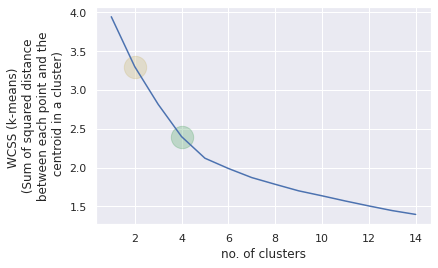

In [594]:
# Scree plot
plt.plot(k_candidates, wcss_kmeans)
plt.scatter(k_candidates[1], wcss_kmeans[1], s=500, c='y', alpha = 0.3)
plt.scatter(k_candidates[3], wcss_kmeans[3], s=500, c='g', alpha = 0.3)
plt.xlabel("no. of clusters")
plt.ylabel('WCSS (k-means) \n (Sum of squared distance \n between each point and the \n centroid in a cluster)')

The location of the elbow is ambiguous. I would say it is in the region $[3,6]$. From visual inspection I would personally determine the elbow to be at $k=4$ clusters. Will however also check Silhouette and Gap-Statistic below.

**Optimal $k$ using Gap-Statistic:**

In [ ]:
# Optimal K using GAP-stat

optimalK = OptimalK()

n_clusters = optimalK(X_train, cluster_array=k_candidates)
print('Optimal clusters: ', n_clusters)

Optimal clusters:  2


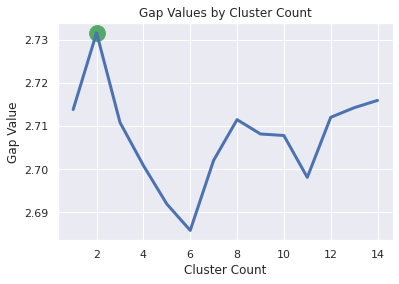

In [ ]:
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='g')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

In [ ]:
optimalK.gap_df.head(6)

,n_clusters,gap_value,gap*,ref_dispersion_std,sk,sk*,diff,diff*
0,1.0,2.713818,4.379979e+06,7522.825845,0.001851,5.057572e+06,0.008975,4.986426e+06
1,2.0,2.731592,3.911318e+06,96123.397554,0.026749,4.517765e+06,0.023103,4.464998e+06
2,3.0,2.710835,3.578979e+06,7786.591953,0.002346,4.132658e+06,0.014467,4.102473e+06
3,4.0,2.700867,3.383698e+06,14115.240447,0.004499,3.907192e+06,0.012857,3.887363e+06
4,5.0,2.691960,3.255577e+06,11950.360091,0.003951,3.759242e+06,0.011134,3.743202e+06
5,6.0,2.685843,3.151802e+06,14690.519991,0.005017,3.639426e+06,-0.015524,3.627386e+06


So the value of 3 clusters by the GAP statistic is not too different than the visually chosen one of 5 from the Scree Plot.

**Using Silhouette Statistic**

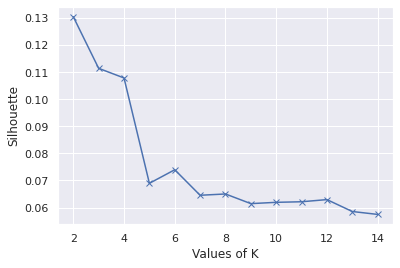

Max average silhouette score is : 0.13047  for n_clusters = 2
CPU times: user 1min 41s, sys: 26.3 s, total: 2min 7s
Wall time: 1min 16s


In [ ]:
%%time
# >2 necessary to calculate Silhouette distances
silhouette_by_k=[]
K = range(2, 15)

for n_clusters in K:
    # Initialize the clusterer
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)

    # Fit, Predict
    cluster_labels = clusterer.fit_predict(X_train)

    #Avg Silhouette Score
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    silhouette_by_k.append(silhouette_avg)

# Plot Results
plt.plot(K, silhouette_by_k, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Silhouette') 
plt.show() 
    
print("Max average silhouette score is :", round(max(silhouette_by_k),5), 
      " for n_clusters =", K[silhouette_by_k.index(max(silhouette_by_k))])

As both Silhouette and Gap-statistic determine the best cluster number to be $k=2$, this is will be the choice. This is also motivated by different runs and finding that predict responses does the best with $k=2$ clusters for the $k$-means algorithm.

### 3.1.2 $k=2$ Means Clustering

Add predicted labels from $k$=2 mean-clustering to dataset.

In [616]:
# Data
X = X_train

# Instantiate clusterer
k = 2
fourmean_clusterer = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)

# Fit
fourmean_clusterer.fit(X)

# Predict labels
fourmean_labels = fourmean_clusterer.predict(X)

Create dataset with predicted cluster labels, using $k$-means clustering, as column.

In [617]:
# Copy original df
X_kmeans_clustrd = X_train.copy()

# Add predicted cluster labels
X_kmeans_clustrd['kmeans_cluster'] = pd.Series(fourmean_labels, index = X_kmeans_clustrd.index)
X_kmeans_clustrd

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,age_at_admin,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU,kmeans_cluster
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
92295,-0.121152,-0.677327,-0.534884,0.675057,-0.334557,0.609659,-0.287071,0.021940,0.086398,0.037469,-0.335269,0.129819,0.590701,-0.765860,-0.328615,-0.717840,0.303666,0.406066,0.269365,0.397473,0.670963,0.677407,-0.113520,0.267633,0.087451,1,1,0,0,1,0,0,0,0,0,0,1
27002,-0.734550,-1.488229,-1.328842,-0.303656,-0.884276,-0.504762,0.383609,-0.661793,-0.037246,0.177313,-0.661588,-0.391616,-0.542477,-1.242651,-0.873260,0.569066,-0.481616,-0.183087,0.555068,0.397473,1.020671,-0.265600,0.184277,-0.058431,0.315713,1,1,0,0,0,1,0,0,1,0,0,1
55036,-0.530084,-0.915828,-0.638745,0.502343,-0.123127,0.407287,1.305793,0.021940,1.364054,0.946454,-0.190238,1.026835,-1.392361,-0.447999,-0.600703,0.971224,0.874781,0.820047,-0.159189,-0.487580,-0.788855,-0.083082,-0.124155,0.136523,0.120872,1,1,0,0,0,1,0,0,0,0,1,0
56112,-1.347948,2.804782,-0.538730,-0.015799,0.638021,-0.206433,0.467443,-0.504008,0.222636,0.736688,-0.045207,0.586736,0.590701,-1.242651,-0.233623,1.132087,-0.767174,0.142624,0.126514,0.397473,0.786362,-1.299864,2.481569,1.514882,1.015660,0,1,0,0,1,0,0,0,1,0,0,0
55238,-1.484258,-0.963528,-1.403529,-0.246085,0.595735,-0.198430,0.886618,1.494596,1.414981,0.596844,1.223811,1.401791,1.723880,0.028792,1.563367,-5.431132,-0.553006,-3.936484,0.697920,0.397473,1.316661,-0.630634,-0.241147,-0.242147,-0.759272,0,1,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86270,-0.052997,-0.200326,0.379968,0.041772,-1.180278,-0.659786,0.467443,-0.609198,0.274673,0.317157,-0.697845,-0.160706,1.157291,0.664513,1.932432,-1.119998,-0.909953,-1.210512,-0.444892,-2.257686,-1.329301,-0.235180,-0.060342,-0.447362,-0.044510,1,1,0,0,0,1,0,0,1,0,0,1
55677,-1.484258,-0.295726,-0.446658,-0.821798,2.329463,-0.262715,-2.047604,-1.608500,-2.065887,-0.941437,-0.153980,-1.736672,-0.825772,-0.130139,-0.147697,1.775540,-0.196059,0.909002,0.269365,0.397473,0.168123,-1.664899,0.396989,-0.157846,1.017382,1,1,0,0,1,0,0,1,0,0,0,1
54193,-0.461929,-0.009525,-0.349717,-2.088369,-0.757418,-0.981672,-0.622411,-0.714388,-0.851722,-0.591828,-0.480299,-0.679089,2.007175,3.048468,1.235796,-1.666933,0.303666,-0.889249,-1.159149,0.397473,0.881142,-0.417697,0.843685,0.487756,1.031853,1,1,0,0,1,0,0,0,0,1,0,1


Inspection of distribution of characteristics/features across the two clusters.

0         AxesSubplot(0.1,0.559091;0.363636x0.340909)
1    AxesSubplot(0.536364,0.559091;0.363636x0.340909)
dtype: object

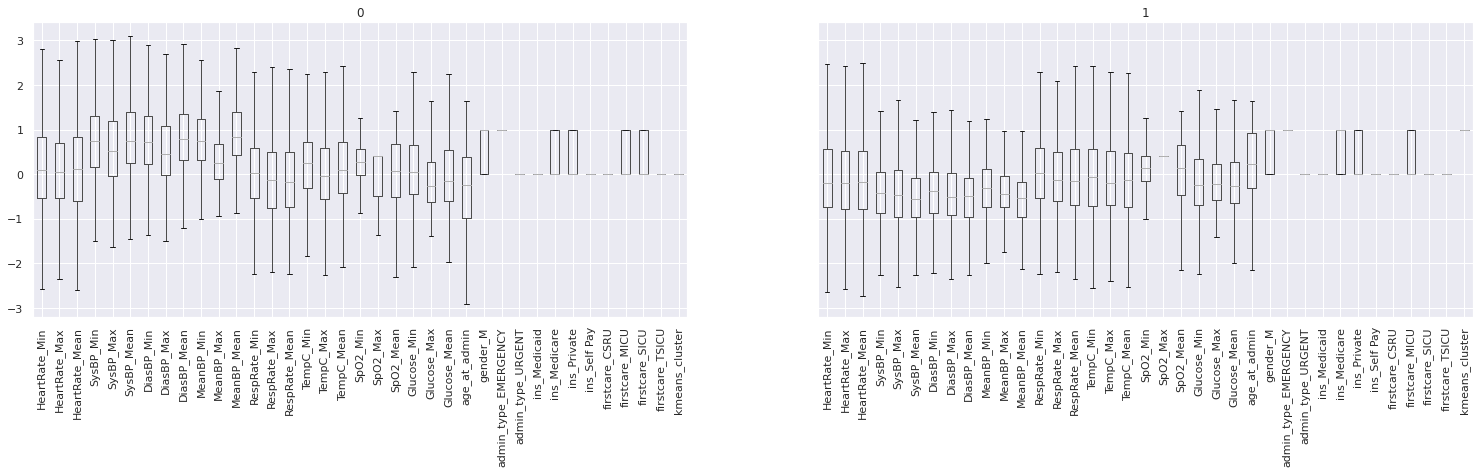

In [618]:
X_kmeans_clustrd.groupby('kmeans_cluster').boxplot(rot=90, figsize = [25,12], layout = (2, 2), showfliers=False )

In [619]:
# Predict labels on test
fourmean_lbls_test = fourmean_clusterer.predict(X_test)

# Copy test df
X_kmeans_clustrd_test = X_test.copy()

# Add predicted cluster labels to test
X_kmeans_clustrd_test['kmeans_cluster'] = pd.Series(fourmean_lbls_test, index = X_kmeans_clustrd_test.index)
X_kmeans_clustrd_test

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,age_at_admin,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU,kmeans_cluster
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
76524,0.219624,-0.104926,0.356685,-0.533942,0.764879,0.671358,-2.215274,-1.292931,-1.149463,-0.871515,-0.480299,-0.476797,0.590701,1.618095,1.483969,0.729929,0.446445,0.493881,-0.302040,-0.487580,-1.380298,1.955028,1.205296,1.858047,0.317264,0,0,0,0,1,0,0,0,0,0,0,1
59020,-0.598239,-1.058928,-0.901602,0.041772,0.638021,0.170834,0.383609,1.179026,0.652051,0.177313,0.498657,0.370603,-0.259183,-0.924790,-0.549493,0.086476,-0.981342,-0.757870,0.555068,-0.487580,0.307428,-0.204760,-0.070977,-0.017388,-0.803546,0,1,0,0,0,1,0,0,1,0,0,0
80187,0.015159,0.705977,1.017609,1.308342,0.172875,1.191508,0.802783,1.494596,1.612938,1.016376,0.716203,1.545468,0.307407,-0.447999,0.147154,-0.959135,-0.553006,-0.987783,-0.730595,0.397473,-1.355026,1.407476,0.258727,0.894678,0.087451,0,1,0,0,1,0,0,0,1,0,0,0
75026,-1.007171,0.801377,-1.060895,-0.073371,-0.249985,-0.553172,-1.460760,-0.661793,-0.512131,-0.172296,-0.879134,-0.729430,0.024112,-1.401581,-1.015175,-0.154818,0.089498,-0.153477,0.126514,0.397473,-0.401763,-0.387278,-0.772928,-0.838247,0.597897,0,1,0,0,1,0,0,0,0,0,1,1
23161,-0.939016,-0.820428,-0.705421,-1.570226,-1.349422,-2.017841,-0.957750,-1.082552,-1.180344,-1.011359,-1.024164,-1.644521,1.157291,0.346652,0.995624,2.821151,0.732002,2.154366,-1.587703,-10.223163,-6.252588,2.837195,0.599066,1.840946,1.286301,1,1,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57449,1.787196,1.135278,1.623989,-0.015799,-0.292271,-0.556514,0.802783,-0.766983,0.142147,0.526922,-0.661588,-0.063098,2.290469,-0.447999,0.425242,1.132087,2.659515,2.310037,0.269365,0.397473,0.168123,-0.630634,-0.475131,-0.710558,-2.200166,1,1,0,0,0,0,0,0,1,0,0,0
50328,-0.461929,-0.963528,-0.818201,-0.418799,-1.222564,-1.001113,-2.215274,-0.609198,-0.371211,-0.312140,-0.262753,-0.547230,-0.259183,-0.765860,-0.488688,0.890792,-0.481616,0.238421,-0.016337,-0.487580,-0.282830,0.707826,0.003472,0.294234,0.582909,0,1,0,0,1,0,0,1,0,0,0,1
91121,2.605060,1.564579,2.048389,-0.821798,-0.630560,-1.186895,-0.957750,-0.766983,-0.905392,-0.591828,-0.190238,-0.920540,0.590701,0.505582,0.402649,4.108057,1.945621,3.735020,-5.016138,0.397473,-3.187870,0.738246,0.311905,0.746467,0.875946,0,1,0,0,1,0,0,0,1,0,0,1


## 3.2 $k$-Medoids

### 3.2.1 Optimal $k$ Search

In [ ]:
%%time
# Estimate k-medoids for n clusters and save the inertia/within-cluster sum-of-squares
k_candidates = range(1, 15)

wcss_med = []
for i in k_candidates:
    kmediods = KMedoids(n_clusters=i, 
                        init='k-medoids++', 
                        max_iter=300, 
                        random_state=0)
    kmediods.fit(X_train) 
    wcss_med.append(kmediods.inertia_)

CPU times: user 1min 32s, sys: 3.7 s, total: 1min 36s
Wall time: 1min 30s


Text(0, 0.5, 'WCSS (k-medioids) \n (Sum of squared distance \n between each point and the \n centroid in a cluster)')

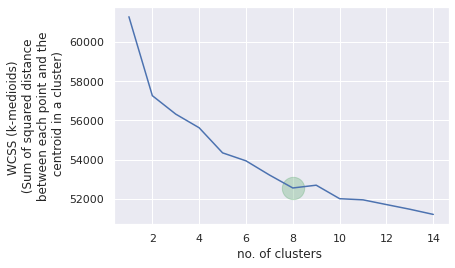

In [ ]:
# Scree plot
plt.plot(k_candidates, wcss_med)
plt.scatter(k_candidates[7], wcss_med[7], s=500, c='g', alpha = 0.3)
plt.xlabel("no. of clusters ")
plt.ylabel('WCSS (k-medioids) \n (Sum of squared distance \n between each point and the \n centroid in a cluster)')

The location of the elbow is again ambiguous. Choice is not clear-cut but I will choose it to be at $k=8$ number of clusters.

### 3.2.2 $k=8$ Medoid Clustering

Add predicted labels from $k$=8 medioid-clustering to dataset.

In [ ]:
%%time
# Data
X = X_train

# Instantiate clusterer
k = 8
eightmean_kmed_clusterer = KMedoids(n_clusters=k, 
                        init='k-medoids++', 
                        max_iter=300, 
                        random_state=0)

# Fit
eightmean_kmed_clusterer.fit(X)

# Predict
eightmean_kmed_lbls = eightmean_kmed_clusterer.predict(X)

CPU times: user 7.77 s, sys: 160 ms, total: 7.93 s
Wall time: 8.9 s


Create dataset with predicted cluster labels, using $k$-medioids clustering, as column.

In [ ]:
# Copy original df
X_kmed_clustrd = X_train.copy()

# Add predicted cluster labels
X_kmed_clustrd['kmed_cluster'] = pd.Series(eightmean_kmed_lbls, index = X_kmed_clustrd.index)
X_kmed_clustrd

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,age_at_admin,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU,kmed_cluster
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
92295,-0.121152,-0.677327,-0.534884,0.675057,-0.334557,0.609659,-0.287071,0.021940,0.086398,0.037469,-0.335269,0.129819,0.590701,-0.765860,-0.328615,-0.717840,0.303666,0.406066,0.269365,0.397473,0.670963,0.677407,-0.113520,0.267633,0.087451,1,1,0,0,1,0,0,0,0,0,0,5
27002,-0.734550,-1.488229,-1.328842,-0.303656,-0.884276,-0.504762,0.383609,-0.661793,-0.037246,0.177313,-0.661588,-0.391616,-0.542477,-1.242651,-0.873260,0.569066,-0.481616,-0.183087,0.555068,0.397473,1.020671,-0.265600,0.184277,-0.058431,0.315713,1,1,0,0,0,1,0,0,1,0,0,2
55036,-0.530084,-0.915828,-0.638745,0.502343,-0.123127,0.407287,1.305793,0.021940,1.364054,0.946454,-0.190238,1.026835,-1.392361,-0.447999,-0.600703,0.971224,0.874781,0.820047,-0.159189,-0.487580,-0.788855,-0.083082,-0.124155,0.136523,0.120872,1,1,0,0,0,1,0,0,0,0,1,7
56112,-1.347948,2.804782,-0.538730,-0.015799,0.638021,-0.206433,0.467443,-0.504008,0.222636,0.736688,-0.045207,0.586736,0.590701,-1.242651,-0.233623,1.132087,-0.767174,0.142624,0.126514,0.397473,0.786362,-1.299864,2.481569,1.514882,1.015660,0,1,0,0,1,0,0,0,1,0,0,5
55238,-1.484258,-0.963528,-1.403529,-0.246085,0.595735,-0.198430,0.886618,1.494596,1.414981,0.596844,1.223811,1.401791,1.723880,0.028792,1.563367,-5.431132,-0.553006,-3.936484,0.697920,0.397473,1.316661,-0.630634,-0.241147,-0.242147,-0.759272,0,1,0,0,0,1,0,0,1,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86270,-0.052997,-0.200326,0.379968,0.041772,-1.180278,-0.659786,0.467443,-0.609198,0.274673,0.317157,-0.697845,-0.160706,1.157291,0.664513,1.932432,-1.119998,-0.909953,-1.210512,-0.444892,-2.257686,-1.329301,-0.235180,-0.060342,-0.447362,-0.044510,1,1,0,0,0,1,0,0,1,0,0,5
55677,-1.484258,-0.295726,-0.446658,-0.821798,2.329463,-0.262715,-2.047604,-1.608500,-2.065887,-0.941437,-0.153980,-1.736672,-0.825772,-0.130139,-0.147697,1.775540,-0.196059,0.909002,0.269365,0.397473,0.168123,-1.664899,0.396989,-0.157846,1.017382,1,1,0,0,1,0,0,1,0,0,0,3
54193,-0.461929,-0.009525,-0.349717,-2.088369,-0.757418,-0.981672,-0.622411,-0.714388,-0.851722,-0.591828,-0.480299,-0.679089,2.007175,3.048468,1.235796,-1.666933,0.303666,-0.889249,-1.159149,0.397473,0.881142,-0.417697,0.843685,0.487756,1.031853,1,1,0,0,1,0,0,0,0,1,0,4


In [ ]:
X_kmed_clustrd['kmed_cluster'].value_counts()

5    2063
2    1945
3    1857
6    1686
1    1678
7    1261
0     733
4     485
Name: kmed_cluster, dtype: int64

Inspection of distribution of characteristics/features across the eight clusters.

0         AxesSubplot(0.1,0.679412;0.235294x0.220588)
1    AxesSubplot(0.382353,0.679412;0.235294x0.220588)
2    AxesSubplot(0.664706,0.679412;0.235294x0.220588)
3         AxesSubplot(0.1,0.414706;0.235294x0.220588)
4    AxesSubplot(0.382353,0.414706;0.235294x0.220588)
5    AxesSubplot(0.664706,0.414706;0.235294x0.220588)
6             AxesSubplot(0.1,0.15;0.235294x0.220588)
7        AxesSubplot(0.382353,0.15;0.235294x0.220588)
dtype: object

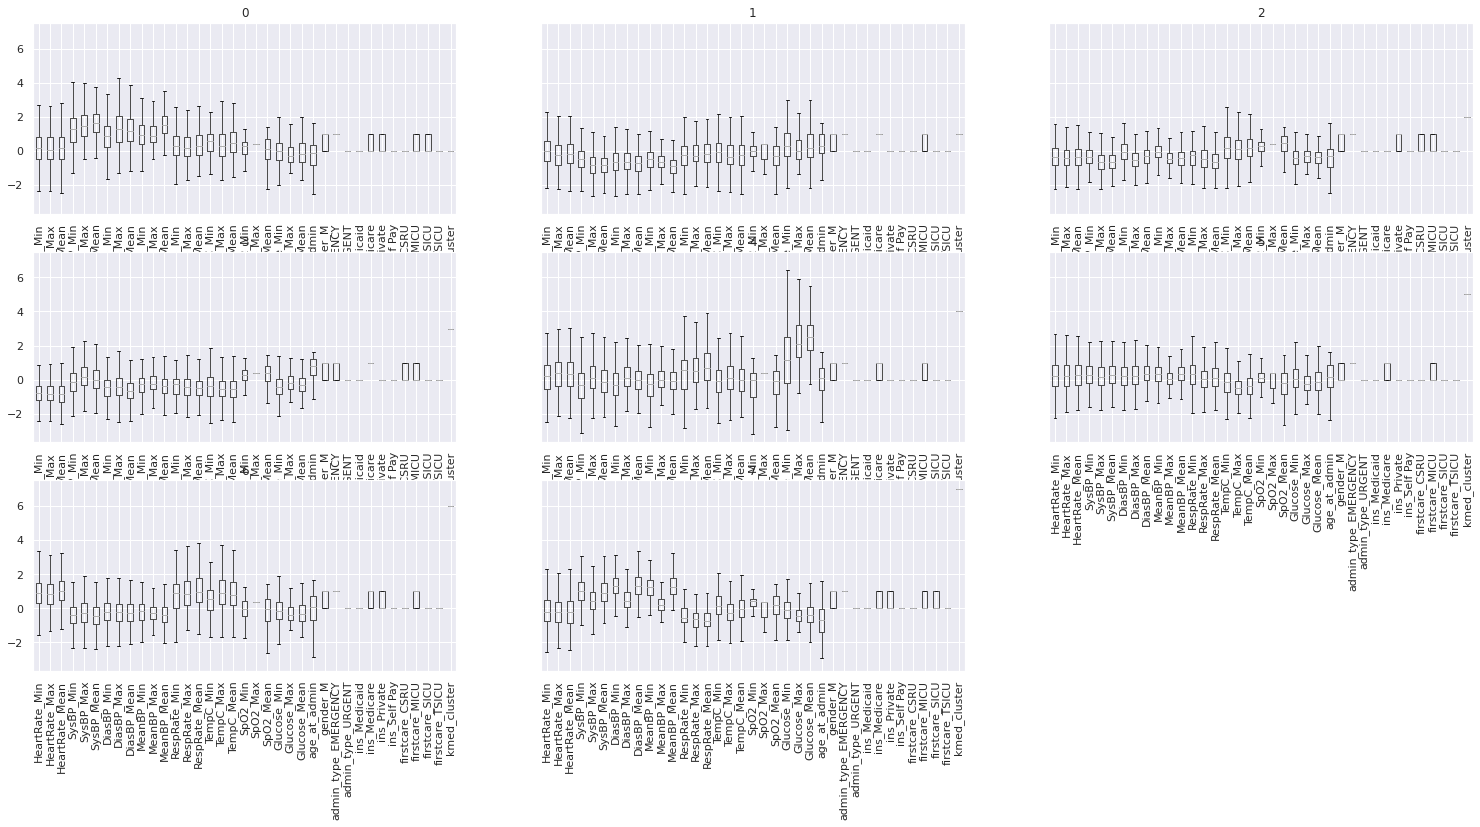

In [ ]:
X_kmed_clustrd.groupby('kmed_cluster').boxplot(rot=90, figsize = [25,12], layout = (3, 3), showfliers=False )

In [ ]:
# Predict labels on test
eightmean_kmed_lbls_test = eightmean_kmed_clusterer.predict(X_test)

# Copy test df
X_kmed_clustrd_test = X_test.copy()

# Add predicted cluster labels to test
X_kmed_clustrd_test['kmed_cluster'] = pd.Series(eightmean_kmed_lbls_test, index = X_kmed_clustrd_test.index)
X_kmed_clustrd_test

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,age_at_admin,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU,kmed_cluster
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
76524,0.219624,-0.104926,0.356685,-0.533942,0.764879,0.671358,-2.215274,-1.292931,-1.149463,-0.871515,-0.480299,-0.476797,0.590701,1.618095,1.483969,0.729929,0.446445,0.493881,-0.302040,-0.487580,-1.380298,1.955028,1.205296,1.858047,0.317264,0,0,0,0,1,0,0,0,0,0,0,4
59020,-0.598239,-1.058928,-0.901602,0.041772,0.638021,0.170834,0.383609,1.179026,0.652051,0.177313,0.498657,0.370603,-0.259183,-0.924790,-0.549493,0.086476,-0.981342,-0.757870,0.555068,-0.487580,0.307428,-0.204760,-0.070977,-0.017388,-0.803546,0,1,0,0,0,1,0,0,1,0,0,5
80187,0.015159,0.705977,1.017609,1.308342,0.172875,1.191508,0.802783,1.494596,1.612938,1.016376,0.716203,1.545468,0.307407,-0.447999,0.147154,-0.959135,-0.553006,-0.987783,-0.730595,0.397473,-1.355026,1.407476,0.258727,0.894678,0.087451,0,1,0,0,1,0,0,0,1,0,0,5
75026,-1.007171,0.801377,-1.060895,-0.073371,-0.249985,-0.553172,-1.460760,-0.661793,-0.512131,-0.172296,-0.879134,-0.729430,0.024112,-1.401581,-1.015175,-0.154818,0.089498,-0.153477,0.126514,0.397473,-0.401763,-0.387278,-0.772928,-0.838247,0.597897,0,1,0,0,1,0,0,0,0,0,1,3
23161,-0.939016,-0.820428,-0.705421,-1.570226,-1.349422,-2.017841,-0.957750,-1.082552,-1.180344,-1.011359,-1.024164,-1.644521,1.157291,0.346652,0.995624,2.821151,0.732002,2.154366,-1.587703,-10.223163,-6.252588,2.837195,0.599066,1.840946,1.286301,1,1,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57449,1.787196,1.135278,1.623989,-0.015799,-0.292271,-0.556514,0.802783,-0.766983,0.142147,0.526922,-0.661588,-0.063098,2.290469,-0.447999,0.425242,1.132087,2.659515,2.310037,0.269365,0.397473,0.168123,-0.630634,-0.475131,-0.710558,-2.200166,1,1,0,0,0,0,0,0,1,0,0,6
50328,-0.461929,-0.963528,-0.818201,-0.418799,-1.222564,-1.001113,-2.215274,-0.609198,-0.371211,-0.312140,-0.262753,-0.547230,-0.259183,-0.765860,-0.488688,0.890792,-0.481616,0.238421,-0.016337,-0.487580,-0.282830,0.707826,0.003472,0.294234,0.582909,0,1,0,0,1,0,0,1,0,0,0,1
91121,2.605060,1.564579,2.048389,-0.821798,-0.630560,-1.186895,-0.957750,-0.766983,-0.905392,-0.591828,-0.190238,-0.920540,0.590701,0.505582,0.402649,4.108057,1.945621,3.735020,-5.016138,0.397473,-3.187870,0.738246,0.311905,0.746467,0.875946,0,1,0,0,1,0,0,0,1,0,0,6


## 3.3 Affinity Propagation 

In [ ]:
%%time
# Data
#X = X_train.sample(frac = 0.30)
X = X_train

# Instantiate
af = AffinityPropagation()

# Fit 
af.fit(X)

# Predict labels
af_lbls = af.predict(X)

# Visualize distribution of labels
pd.Series(af_lbls).hist()

247    67
394    63
291    61
22     61
66     61
       ..
361     1
252     1
228     1
196     1
268     1
Length: 579, dtype: int64


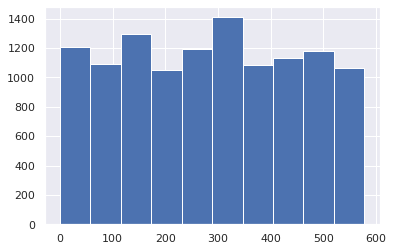

In [ ]:
print(pd.Series(af_lbls).value_counts())
pd.Series(af_lbls).hist()

In [ ]:
# Copy original df
X_af_clustrd = X_train.copy()

# Add predicted cluster labels
X_af_clustrd['af_cluster'] = pd.Series(af_lbls, index = X_af_clustrd.index)
X_af_clustrd

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,age_at_admin,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU,af_cluster
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
92295,-0.121152,-0.677327,-0.534884,0.675057,-0.334557,0.609659,-0.287071,0.021940,0.086398,0.037469,-0.335269,0.129819,0.590701,-0.765860,-0.328615,-0.717840,0.303666,0.406066,0.269365,0.397473,0.670963,0.677407,-0.113520,0.267633,0.087451,1,1,0,0,1,0,0,0,0,0,0,562
27002,-0.734550,-1.488229,-1.328842,-0.303656,-0.884276,-0.504762,0.383609,-0.661793,-0.037246,0.177313,-0.661588,-0.391616,-0.542477,-1.242651,-0.873260,0.569066,-0.481616,-0.183087,0.555068,0.397473,1.020671,-0.265600,0.184277,-0.058431,0.315713,1,1,0,0,0,1,0,0,1,0,0,517
55036,-0.530084,-0.915828,-0.638745,0.502343,-0.123127,0.407287,1.305793,0.021940,1.364054,0.946454,-0.190238,1.026835,-1.392361,-0.447999,-0.600703,0.971224,0.874781,0.820047,-0.159189,-0.487580,-0.788855,-0.083082,-0.124155,0.136523,0.120872,1,1,0,0,0,1,0,0,0,0,1,474
56112,-1.347948,2.804782,-0.538730,-0.015799,0.638021,-0.206433,0.467443,-0.504008,0.222636,0.736688,-0.045207,0.586736,0.590701,-1.242651,-0.233623,1.132087,-0.767174,0.142624,0.126514,0.397473,0.786362,-1.299864,2.481569,1.514882,1.015660,0,1,0,0,1,0,0,0,1,0,0,278
55238,-1.484258,-0.963528,-1.403529,-0.246085,0.595735,-0.198430,0.886618,1.494596,1.414981,0.596844,1.223811,1.401791,1.723880,0.028792,1.563367,-5.431132,-0.553006,-3.936484,0.697920,0.397473,1.316661,-0.630634,-0.241147,-0.242147,-0.759272,0,1,0,0,0,1,0,0,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86270,-0.052997,-0.200326,0.379968,0.041772,-1.180278,-0.659786,0.467443,-0.609198,0.274673,0.317157,-0.697845,-0.160706,1.157291,0.664513,1.932432,-1.119998,-0.909953,-1.210512,-0.444892,-2.257686,-1.329301,-0.235180,-0.060342,-0.447362,-0.044510,1,1,0,0,0,1,0,0,1,0,0,35
55677,-1.484258,-0.295726,-0.446658,-0.821798,2.329463,-0.262715,-2.047604,-1.608500,-2.065887,-0.941437,-0.153980,-1.736672,-0.825772,-0.130139,-0.147697,1.775540,-0.196059,0.909002,0.269365,0.397473,0.168123,-1.664899,0.396989,-0.157846,1.017382,1,1,0,0,1,0,0,1,0,0,0,105
54193,-0.461929,-0.009525,-0.349717,-2.088369,-0.757418,-0.981672,-0.622411,-0.714388,-0.851722,-0.591828,-0.480299,-0.679089,2.007175,3.048468,1.235796,-1.666933,0.303666,-0.889249,-1.159149,0.397473,0.881142,-0.417697,0.843685,0.487756,1.031853,1,1,0,0,1,0,0,0,0,1,0,333


In [ ]:
# Predict labels on test
af_lbls_test = af.predict(X_test)

# Copy test df
X_af_clustrd_test = X_test.copy()

# Add predicted cluster labels to test
X_af_clustrd_test['af_cluster'] = pd.Series(af_lbls_test, index = X_af_clustrd_test.index)
X_af_clustrd_test

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,age_at_admin,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU,af_cluster
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
76524,0.219624,-0.104926,0.356685,-0.533942,0.764879,0.671358,-2.215274,-1.292931,-1.149463,-0.871515,-0.480299,-0.476797,0.590701,1.618095,1.483969,0.729929,0.446445,0.493881,-0.302040,-0.487580,-1.380298,1.955028,1.205296,1.858047,0.317264,0,0,0,0,1,0,0,0,0,0,0,53
59020,-0.598239,-1.058928,-0.901602,0.041772,0.638021,0.170834,0.383609,1.179026,0.652051,0.177313,0.498657,0.370603,-0.259183,-0.924790,-0.549493,0.086476,-0.981342,-0.757870,0.555068,-0.487580,0.307428,-0.204760,-0.070977,-0.017388,-0.803546,0,1,0,0,0,1,0,0,1,0,0,543
80187,0.015159,0.705977,1.017609,1.308342,0.172875,1.191508,0.802783,1.494596,1.612938,1.016376,0.716203,1.545468,0.307407,-0.447999,0.147154,-0.959135,-0.553006,-0.987783,-0.730595,0.397473,-1.355026,1.407476,0.258727,0.894678,0.087451,0,1,0,0,1,0,0,0,1,0,0,141
75026,-1.007171,0.801377,-1.060895,-0.073371,-0.249985,-0.553172,-1.460760,-0.661793,-0.512131,-0.172296,-0.879134,-0.729430,0.024112,-1.401581,-1.015175,-0.154818,0.089498,-0.153477,0.126514,0.397473,-0.401763,-0.387278,-0.772928,-0.838247,0.597897,0,1,0,0,1,0,0,0,0,0,1,66
23161,-0.939016,-0.820428,-0.705421,-1.570226,-1.349422,-2.017841,-0.957750,-1.082552,-1.180344,-1.011359,-1.024164,-1.644521,1.157291,0.346652,0.995624,2.821151,0.732002,2.154366,-1.587703,-10.223163,-6.252588,2.837195,0.599066,1.840946,1.286301,1,1,0,0,1,0,0,0,1,0,0,565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57449,1.787196,1.135278,1.623989,-0.015799,-0.292271,-0.556514,0.802783,-0.766983,0.142147,0.526922,-0.661588,-0.063098,2.290469,-0.447999,0.425242,1.132087,2.659515,2.310037,0.269365,0.397473,0.168123,-0.630634,-0.475131,-0.710558,-2.200166,1,1,0,0,0,0,0,0,1,0,0,160
50328,-0.461929,-0.963528,-0.818201,-0.418799,-1.222564,-1.001113,-2.215274,-0.609198,-0.371211,-0.312140,-0.262753,-0.547230,-0.259183,-0.765860,-0.488688,0.890792,-0.481616,0.238421,-0.016337,-0.487580,-0.282830,0.707826,0.003472,0.294234,0.582909,0,1,0,0,1,0,0,1,0,0,0,105
91121,2.605060,1.564579,2.048389,-0.821798,-0.630560,-1.186895,-0.957750,-0.766983,-0.905392,-0.591828,-0.190238,-0.920540,0.590701,0.505582,0.402649,4.108057,1.945621,3.735020,-5.016138,0.397473,-3.187870,0.738246,0.311905,0.746467,0.875946,0,1,0,0,1,0,0,0,1,0,0,93


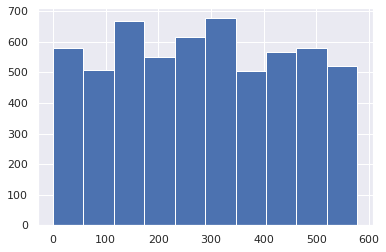

In [ ]:
# Visualize labels on test data
X_af_clustrd_test['af_cluster'].hist()

## 3.4 Mean-Shift

In [ ]:
%%time
# Data 
X = X_train

# Estimate Bandwidth
bandwidth = estimate_bandwidth(X, quantile=0.3)
print(bandwidth)

# Instantiate
mshift = MeanShift(bandwidth=bandwidth)

# Fit
mshift.fit(X)

# Predict
mshift_lbls = mshift.predict(X)

6.0601485834809425
CPU times: user 5min 34s, sys: 15min 37s, total: 21min 12s
Wall time: 11min 1s


In [ ]:
np.unique(mshift.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])

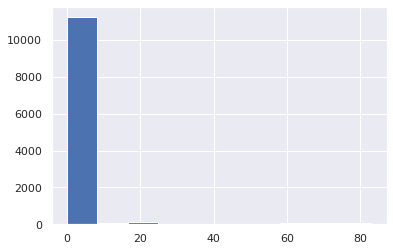

In [ ]:
pd.Series(mshift_lbls).hist()

Create dataset with predicted cluster labels, using mean-shift clustering, as column.

In [ ]:
# Copy original df
X_mshift_clustrd = X_train.copy()

# Add predicted cluster labels
X_mshift_clustrd['mshift_cluster'] = pd.Series(mshift_lbls, index = X_mshift_clustrd.index)
X_mshift_clustrd

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,age_at_admin,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU,mshift_cluster
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
92295,-0.121152,-0.677327,-0.534884,0.675057,-0.334557,0.609659,-0.287071,0.021940,0.086398,0.037469,-0.335269,0.129819,0.590701,-0.765860,-0.328615,-0.717840,0.303666,0.406066,0.269365,0.397473,0.670963,0.677407,-0.113520,0.267633,0.087451,1,1,0,0,1,0,0,0,0,0,0,0
27002,-0.734550,-1.488229,-1.328842,-0.303656,-0.884276,-0.504762,0.383609,-0.661793,-0.037246,0.177313,-0.661588,-0.391616,-0.542477,-1.242651,-0.873260,0.569066,-0.481616,-0.183087,0.555068,0.397473,1.020671,-0.265600,0.184277,-0.058431,0.315713,1,1,0,0,0,1,0,0,1,0,0,0
55036,-0.530084,-0.915828,-0.638745,0.502343,-0.123127,0.407287,1.305793,0.021940,1.364054,0.946454,-0.190238,1.026835,-1.392361,-0.447999,-0.600703,0.971224,0.874781,0.820047,-0.159189,-0.487580,-0.788855,-0.083082,-0.124155,0.136523,0.120872,1,1,0,0,0,1,0,0,0,0,1,0
56112,-1.347948,2.804782,-0.538730,-0.015799,0.638021,-0.206433,0.467443,-0.504008,0.222636,0.736688,-0.045207,0.586736,0.590701,-1.242651,-0.233623,1.132087,-0.767174,0.142624,0.126514,0.397473,0.786362,-1.299864,2.481569,1.514882,1.015660,0,1,0,0,1,0,0,0,1,0,0,0
55238,-1.484258,-0.963528,-1.403529,-0.246085,0.595735,-0.198430,0.886618,1.494596,1.414981,0.596844,1.223811,1.401791,1.723880,0.028792,1.563367,-5.431132,-0.553006,-3.936484,0.697920,0.397473,1.316661,-0.630634,-0.241147,-0.242147,-0.759272,0,1,0,0,0,1,0,0,1,0,0,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86270,-0.052997,-0.200326,0.379968,0.041772,-1.180278,-0.659786,0.467443,-0.609198,0.274673,0.317157,-0.697845,-0.160706,1.157291,0.664513,1.932432,-1.119998,-0.909953,-1.210512,-0.444892,-2.257686,-1.329301,-0.235180,-0.060342,-0.447362,-0.044510,1,1,0,0,0,1,0,0,1,0,0,0
55677,-1.484258,-0.295726,-0.446658,-0.821798,2.329463,-0.262715,-2.047604,-1.608500,-2.065887,-0.941437,-0.153980,-1.736672,-0.825772,-0.130139,-0.147697,1.775540,-0.196059,0.909002,0.269365,0.397473,0.168123,-1.664899,0.396989,-0.157846,1.017382,1,1,0,0,1,0,0,1,0,0,0,0
54193,-0.461929,-0.009525,-0.349717,-2.088369,-0.757418,-0.981672,-0.622411,-0.714388,-0.851722,-0.591828,-0.480299,-0.679089,2.007175,3.048468,1.235796,-1.666933,0.303666,-0.889249,-1.159149,0.397473,0.881142,-0.417697,0.843685,0.487756,1.031853,1,1,0,0,1,0,0,0,0,1,0,0


In [ ]:
# Predict labels on test
mshift_lbls_test = mshift.predict(X_test)

# Copy test df
X_mshift_clustrd_test = X_test.copy()

# Add predicted cluster labels to test
X_mshift_clustrd_test['mshift_cluster'] = pd.Series(af_lbls_test, index = X_mshift_clustrd_test.index)
X_mshift_clustrd_test

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,age_at_admin,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU,mshift_cluster
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
76524,0.219624,-0.104926,0.356685,-0.533942,0.764879,0.671358,-2.215274,-1.292931,-1.149463,-0.871515,-0.480299,-0.476797,0.590701,1.618095,1.483969,0.729929,0.446445,0.493881,-0.302040,-0.487580,-1.380298,1.955028,1.205296,1.858047,0.317264,0,0,0,0,1,0,0,0,0,0,0,-1
59020,-0.598239,-1.058928,-0.901602,0.041772,0.638021,0.170834,0.383609,1.179026,0.652051,0.177313,0.498657,0.370603,-0.259183,-0.924790,-0.549493,0.086476,-0.981342,-0.757870,0.555068,-0.487580,0.307428,-0.204760,-0.070977,-0.017388,-0.803546,0,1,0,0,0,1,0,0,1,0,0,-1
80187,0.015159,0.705977,1.017609,1.308342,0.172875,1.191508,0.802783,1.494596,1.612938,1.016376,0.716203,1.545468,0.307407,-0.447999,0.147154,-0.959135,-0.553006,-0.987783,-0.730595,0.397473,-1.355026,1.407476,0.258727,0.894678,0.087451,0,1,0,0,1,0,0,0,1,0,0,-1
75026,-1.007171,0.801377,-1.060895,-0.073371,-0.249985,-0.553172,-1.460760,-0.661793,-0.512131,-0.172296,-0.879134,-0.729430,0.024112,-1.401581,-1.015175,-0.154818,0.089498,-0.153477,0.126514,0.397473,-0.401763,-0.387278,-0.772928,-0.838247,0.597897,0,1,0,0,1,0,0,0,0,0,1,-1
23161,-0.939016,-0.820428,-0.705421,-1.570226,-1.349422,-2.017841,-0.957750,-1.082552,-1.180344,-1.011359,-1.024164,-1.644521,1.157291,0.346652,0.995624,2.821151,0.732002,2.154366,-1.587703,-10.223163,-6.252588,2.837195,0.599066,1.840946,1.286301,1,1,0,0,1,0,0,0,1,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57449,1.787196,1.135278,1.623989,-0.015799,-0.292271,-0.556514,0.802783,-0.766983,0.142147,0.526922,-0.661588,-0.063098,2.290469,-0.447999,0.425242,1.132087,2.659515,2.310037,0.269365,0.397473,0.168123,-0.630634,-0.475131,-0.710558,-2.200166,1,1,0,0,0,0,0,0,1,0,0,-1
50328,-0.461929,-0.963528,-0.818201,-0.418799,-1.222564,-1.001113,-2.215274,-0.609198,-0.371211,-0.312140,-0.262753,-0.547230,-0.259183,-0.765860,-0.488688,0.890792,-0.481616,0.238421,-0.016337,-0.487580,-0.282830,0.707826,0.003472,0.294234,0.582909,0,1,0,0,1,0,0,1,0,0,0,-1
91121,2.605060,1.564579,2.048389,-0.821798,-0.630560,-1.186895,-0.957750,-0.766983,-0.905392,-0.591828,-0.190238,-0.920540,0.590701,0.505582,0.402649,4.108057,1.945621,3.735020,-5.016138,0.397473,-3.187870,0.738246,0.311905,0.746467,0.875946,0,1,0,0,1,0,0,0,1,0,0,-1


In [ ]:
X_mshift_clustrd_test['mshift_cluster'].value_counts()

-1    5768
Name: mshift_cluster, dtype: int64

## 3.5 Spectral Clustering

NB: Just as in the case with Affinity Propagation, the Spectral Clustering Algorithm cannot handle the dataset. It works for restricted sample (first 5,000 out of 17,000 rows) but crashes at the first 10,000 rows.
<br>

Code is left below to show my intention

In [ ]:
print(k)

6


In [ ]:
%%script echo skipping
# Data
X = X_train
#X = X_train.iloc[0:10000,:]

# Instantiate
spectral_clusterer = SpectralClustering(n_clusters=k, 
        assign_labels="discretize",
        random_state=0)

# Fit
spec_labels = spectral_clusterer.fit_predict(X)

skipping


In [ ]:
pd.Series(spec_labels).value_counts()
#spec_labels.shape
#spec_labels

0    4973
1      12
3      10
4       3
2       2
dtype: int64

Create dataset with predicted cluster labels, using spectral clustering, as column.

In [ ]:
# Copy original df
X_spec_clustrd = X_train.copy()

# Add predicted cluster labels
X_spec_clustrd['spec_cluster'] = pd.Series(spec_labels, index = X_spec_clustrd.index)
X_spec_clustrd

# **4. SVD Analysis**

Analysis is extended by using Single Value Decomposition (SVD)

## 4.0 Decomposing Data with SVD

In [568]:
u, s, v = np.linalg.svd(X_train, full_matrices = True) 

In [569]:
print(X_train.shape)
print(u.shape)
print(s.shape)
print(v.shape)

(11708, 36)
(11708, 11708)
(36,)
(36, 36)


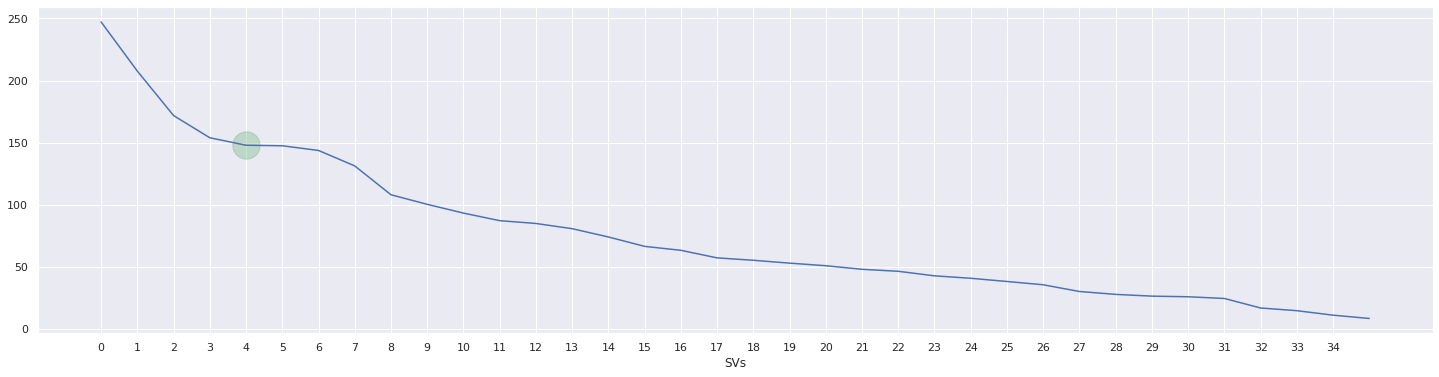

In [570]:
# Plot the single values
plt.plot(s)
plt.scatter(4, s[4], s=750, c='g', alpha = 0.3)
plt.xlabel("SVs")
plt.xticks(np.arange(0, 35, step=1))
plt.gcf().set_size_inches(25, 6)

The elbow is decided to be at $SV=4$.

In [571]:
labels= ['SV'+str(i) for i in range(1,5)]
X_svd = pd.DataFrame(u[:,0:4], columns = labels)
X_svd

,SV1,SV2,SV3,SV4
0,0.000837,0.004478,-0.000929,0.002117
1,-0.004060,0.011635,0.005427,0.000468
2,0.007955,0.005032,0.003589,-0.003032
3,0.002511,0.000725,-0.005111,0.010217
4,0.004823,0.012967,-0.017738,-0.014447
...,...,...,...,...
11703,-0.003199,-0.005004,-0.010536,-0.021691
11704,-0.011660,0.003498,0.003614,0.007715
11705,-0.012084,-0.008498,-0.011484,-0.002324
11706,0.008036,0.002264,0.005996,0.002719


Same procedure is now carried out for test set but without inspection of scree plot. Simply adopt conclusions from inspected training data.

In [572]:
u, s, v = np.linalg.svd(X_test, full_matrices = True) 
labels= ['SV'+str(i) for i in range(1,5)]
X_test_svd = pd.DataFrame(u[:,0:4], columns = labels)
X_test_svd

,SV1,SV2,SV3,SV4
0,0.008321,0.016419,0.022191,0.015978
1,-0.005585,-0.014189,0.002656,-0.002702
2,-0.017470,-0.000909,0.021394,-0.006126
3,0.012262,-0.007596,-0.007079,-0.001152
4,0.019269,0.024428,0.027941,0.013065
...,...,...,...,...
5763,-0.007839,0.026059,-0.025258,0.010123
5764,0.014386,-0.004146,0.001424,0.010429
5765,0.006100,0.045779,-0.002175,0.011083
5766,0.002794,0.002267,0.008556,0.005353


## 4.1 $k$-Means Clustering

### 4.1.1 Optimal $k$ Search

$k$-means clustering with on SVD'd data with different values of clusters and inspection of results.

In [573]:
%%time
# Estimate k-means for n clusters and save the inertia/within-cluster sum-of-squares
k_candidates = range(1, 15)
wcss_kmeans = []

for i in k_candidates:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_svd) 
    wcss_kmeans.append(kmeans.inertia_)

CPU times: user 46 s, sys: 16 s, total: 1min 2s
Wall time: 42.2 s


Text(0, 0.5, 'WCSS (k-means) \n (Sum of squared distance \n between each point and the \n centroid in a cluster)')

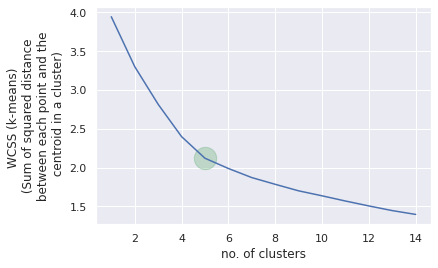

In [574]:
# Scree plot
plt.plot(k_candidates, wcss_kmeans)
plt.scatter(k_candidates[4], wcss_kmeans[4], s=500, c='g', alpha = 0.3)
plt.xlabel("no. of clusters")
plt.ylabel('WCSS (k-means) \n (Sum of squared distance \n between each point and the \n centroid in a cluster)')

The location of the elbow is more pronounced in the non-SVD'd case. It is again decided, for the $k$-means clustering method, that the elbow is located at $k=5$ clusters.

**Optimal $k$ using Gap-Statistic:**

**Using Silhouette Statistic**

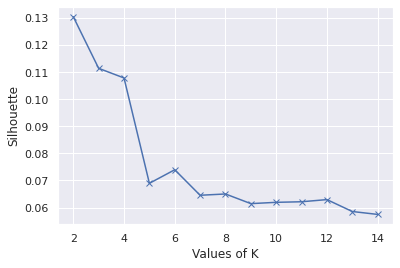

Max average silhouette score is : 0.13047  for n_clusters = 2
CPU times: user 1min 54s, sys: 27.6 s, total: 2min 21s
Wall time: 1min 47s


In [575]:
%%time
# >2 necessary to calculate Silhouette distances
silhouette_by_k=[]
K = range(2, 15)

for n_clusters in K:
    # Initialize the clusterer
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)

    # Fit, Predict
    cluster_labels = clusterer.fit_predict(X_train)

    #Avg Silhouette Score
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    silhouette_by_k.append(silhouette_avg)

# Plot Results
plt.plot(K, silhouette_by_k, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Silhouette') 
plt.show() 
    
print("Max average silhouette score is :", round(max(silhouette_by_k),5), 
      " for n_clusters =", K[silhouette_by_k.index(max(silhouette_by_k))])

### 4.1.2 $k=5$ Means Clustering

Add predicted labels from $k$=5 mean-clustering to SVD'd dataset.

In [576]:
# Data
X = X_svd

# Instantiate clusterer
k = 5
fivemean_clusterer = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)

# Fit
fivemean_clusterer.fit(X)

# Predict labels
fivemean_lbls = fivemean_clusterer.predict(X)

Create dataset with predicted cluster labels, using $k$-means clustering, as column.

In [577]:
# Copy original df
X_svd_kmeans_clustrd = X_train.copy()

# Add predicted cluster labels
X_svd_kmeans_clustrd['kmeans_cluster'] = pd.Series(fivemean_lbls, index = X_svd_kmeans_clustrd.index)
X_svd_kmeans_clustrd

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,age_at_admin,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU,kmeans_cluster
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
92295,-0.121152,-0.677327,-0.534884,0.675057,-0.334557,0.609659,-0.287071,0.021940,0.086398,0.037469,-0.335269,0.129819,0.590701,-0.765860,-0.328615,-0.717840,0.303666,0.406066,0.269365,0.397473,0.670963,0.677407,-0.113520,0.267633,0.087451,1,1,0,0,1,0,0,0,0,0,0,0
27002,-0.734550,-1.488229,-1.328842,-0.303656,-0.884276,-0.504762,0.383609,-0.661793,-0.037246,0.177313,-0.661588,-0.391616,-0.542477,-1.242651,-0.873260,0.569066,-0.481616,-0.183087,0.555068,0.397473,1.020671,-0.265600,0.184277,-0.058431,0.315713,1,1,0,0,0,1,0,0,1,0,0,0
55036,-0.530084,-0.915828,-0.638745,0.502343,-0.123127,0.407287,1.305793,0.021940,1.364054,0.946454,-0.190238,1.026835,-1.392361,-0.447999,-0.600703,0.971224,0.874781,0.820047,-0.159189,-0.487580,-0.788855,-0.083082,-0.124155,0.136523,0.120872,1,1,0,0,0,1,0,0,0,0,1,4
56112,-1.347948,2.804782,-0.538730,-0.015799,0.638021,-0.206433,0.467443,-0.504008,0.222636,0.736688,-0.045207,0.586736,0.590701,-1.242651,-0.233623,1.132087,-0.767174,0.142624,0.126514,0.397473,0.786362,-1.299864,2.481569,1.514882,1.015660,0,1,0,0,1,0,0,0,1,0,0,1
55238,-1.484258,-0.963528,-1.403529,-0.246085,0.595735,-0.198430,0.886618,1.494596,1.414981,0.596844,1.223811,1.401791,1.723880,0.028792,1.563367,-5.431132,-0.553006,-3.936484,0.697920,0.397473,1.316661,-0.630634,-0.241147,-0.242147,-0.759272,0,1,0,0,0,1,0,0,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86270,-0.052997,-0.200326,0.379968,0.041772,-1.180278,-0.659786,0.467443,-0.609198,0.274673,0.317157,-0.697845,-0.160706,1.157291,0.664513,1.932432,-1.119998,-0.909953,-1.210512,-0.444892,-2.257686,-1.329301,-0.235180,-0.060342,-0.447362,-0.044510,1,1,0,0,0,1,0,0,1,0,0,2
55677,-1.484258,-0.295726,-0.446658,-0.821798,2.329463,-0.262715,-2.047604,-1.608500,-2.065887,-0.941437,-0.153980,-1.736672,-0.825772,-0.130139,-0.147697,1.775540,-0.196059,0.909002,0.269365,0.397473,0.168123,-1.664899,0.396989,-0.157846,1.017382,1,1,0,0,1,0,0,1,0,0,0,0
54193,-0.461929,-0.009525,-0.349717,-2.088369,-0.757418,-0.981672,-0.622411,-0.714388,-0.851722,-0.591828,-0.480299,-0.679089,2.007175,3.048468,1.235796,-1.666933,0.303666,-0.889249,-1.159149,0.397473,0.881142,-0.417697,0.843685,0.487756,1.031853,1,1,0,0,1,0,0,0,0,1,0,2


In [578]:
# Predict labels on test
fivemean_lbls_test = fivemean_clusterer.predict(X_test_svd)

# Copy test df
X_svd_kmeans_clustrd_test = X_test.copy()

# Add predicted cluster labels to test
X_svd_kmeans_clustrd_test['kmeans_cluster'] = pd.Series(fivemean_lbls_test, index = X_svd_kmeans_clustrd_test.index)
X_svd_kmeans_clustrd_test

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,age_at_admin,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU,kmeans_cluster
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
76524,0.219624,-0.104926,0.356685,-0.533942,0.764879,0.671358,-2.215274,-1.292931,-1.149463,-0.871515,-0.480299,-0.476797,0.590701,1.618095,1.483969,0.729929,0.446445,0.493881,-0.302040,-0.487580,-1.380298,1.955028,1.205296,1.858047,0.317264,0,0,0,0,1,0,0,0,0,0,0,0
59020,-0.598239,-1.058928,-0.901602,0.041772,0.638021,0.170834,0.383609,1.179026,0.652051,0.177313,0.498657,0.370603,-0.259183,-0.924790,-0.549493,0.086476,-0.981342,-0.757870,0.555068,-0.487580,0.307428,-0.204760,-0.070977,-0.017388,-0.803546,0,1,0,0,0,1,0,0,1,0,0,3
80187,0.015159,0.705977,1.017609,1.308342,0.172875,1.191508,0.802783,1.494596,1.612938,1.016376,0.716203,1.545468,0.307407,-0.447999,0.147154,-0.959135,-0.553006,-0.987783,-0.730595,0.397473,-1.355026,1.407476,0.258727,0.894678,0.087451,0,1,0,0,1,0,0,0,1,0,0,3
75026,-1.007171,0.801377,-1.060895,-0.073371,-0.249985,-0.553172,-1.460760,-0.661793,-0.512131,-0.172296,-0.879134,-0.729430,0.024112,-1.401581,-1.015175,-0.154818,0.089498,-0.153477,0.126514,0.397473,-0.401763,-0.387278,-0.772928,-0.838247,0.597897,0,1,0,0,1,0,0,0,0,0,1,4
23161,-0.939016,-0.820428,-0.705421,-1.570226,-1.349422,-2.017841,-0.957750,-1.082552,-1.180344,-1.011359,-1.024164,-1.644521,1.157291,0.346652,0.995624,2.821151,0.732002,2.154366,-1.587703,-10.223163,-6.252588,2.837195,0.599066,1.840946,1.286301,1,1,0,0,1,0,0,0,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57449,1.787196,1.135278,1.623989,-0.015799,-0.292271,-0.556514,0.802783,-0.766983,0.142147,0.526922,-0.661588,-0.063098,2.290469,-0.447999,0.425242,1.132087,2.659515,2.310037,0.269365,0.397473,0.168123,-0.630634,-0.475131,-0.710558,-2.200166,1,1,0,0,0,0,0,0,1,0,0,1
50328,-0.461929,-0.963528,-0.818201,-0.418799,-1.222564,-1.001113,-2.215274,-0.609198,-0.371211,-0.312140,-0.262753,-0.547230,-0.259183,-0.765860,-0.488688,0.890792,-0.481616,0.238421,-0.016337,-0.487580,-0.282830,0.707826,0.003472,0.294234,0.582909,0,1,0,0,1,0,0,1,0,0,0,4
91121,2.605060,1.564579,2.048389,-0.821798,-0.630560,-1.186895,-0.957750,-0.766983,-0.905392,-0.591828,-0.190238,-0.920540,0.590701,0.505582,0.402649,4.108057,1.945621,3.735020,-5.016138,0.397473,-3.187870,0.738246,0.311905,0.746467,0.875946,0,1,0,0,1,0,0,0,1,0,0,0


## 4.2 $k$-Medoids

### 4.2.1 Optimal $k$ Search

In [579]:
%%time
# Estimate k-medoids for n clusters and save the inertia/within-cluster sum-of-squares
k_candidates = range(1, 15)

wcss_med = []
for i in k_candidates:
    kmediods = KMedoids(n_clusters=i, 
                        init='k-medoids++', 
                        max_iter=300, 
                        random_state=0)
    kmediods.fit(X_svd) 
    wcss_med.append(kmediods.inertia_)

CPU times: user 1min 50s, sys: 5.07 s, total: 1min 55s
Wall time: 1min 51s


Text(0, 0.5, 'WCSS (k-medioids) \n (Sum of squared distance \n between each point and the \n centroid in a cluster)')

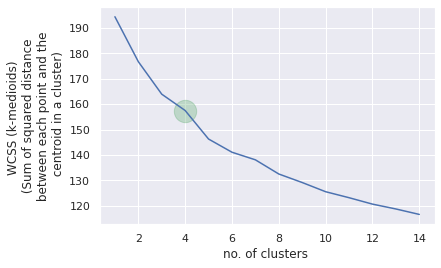

In [580]:
# Scree plot
plt.plot(k_candidates, wcss_med)
plt.scatter(k_candidates[3], wcss_med[3], s=500, c='g', alpha = 0.3)
plt.xlabel("no. of clusters ")
plt.ylabel('WCSS (k-medioids) \n (Sum of squared distance \n between each point and the \n centroid in a cluster)')

I decide that the elbow is located at $k=4$ clusters.

### 4.2.2 $k=4$ Medoid Clustering

Add predicted labels from $k$=4 medioid-clustering to dataset.

In [581]:
# Data
X = X_svd

# Instantiate clusterer
k = 6
fourmean_kmed_clusterer_svd = KMedoids(n_clusters=k, 
                        init='k-medoids++', 
                        max_iter=300, 
                        random_state=0)

# Fit
fourmean_kmed_clusterer_svd.fit(X)

# Predict
fourmean_kmed_lbls_svd = fourmean_kmed_clusterer_svd.predict(X)

Create dataset with predicted cluster labels, using $k$-medioids clustering, as column.

In [582]:
# Copy original df
X_kmed_clustrd_svd = X_train.copy()

# Add predicted cluster labels
X_kmed_clustrd_svd['kmed_cluster'] = pd.Series(fourmean_kmed_lbls_svd, index = X_kmed_clustrd_svd.index)
X_kmed_clustrd_svd

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,age_at_admin,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU,kmed_cluster
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
92295,-0.121152,-0.677327,-0.534884,0.675057,-0.334557,0.609659,-0.287071,0.021940,0.086398,0.037469,-0.335269,0.129819,0.590701,-0.765860,-0.328615,-0.717840,0.303666,0.406066,0.269365,0.397473,0.670963,0.677407,-0.113520,0.267633,0.087451,1,1,0,0,1,0,0,0,0,0,0,1
27002,-0.734550,-1.488229,-1.328842,-0.303656,-0.884276,-0.504762,0.383609,-0.661793,-0.037246,0.177313,-0.661588,-0.391616,-0.542477,-1.242651,-0.873260,0.569066,-0.481616,-0.183087,0.555068,0.397473,1.020671,-0.265600,0.184277,-0.058431,0.315713,1,1,0,0,0,1,0,0,1,0,0,2
55036,-0.530084,-0.915828,-0.638745,0.502343,-0.123127,0.407287,1.305793,0.021940,1.364054,0.946454,-0.190238,1.026835,-1.392361,-0.447999,-0.600703,0.971224,0.874781,0.820047,-0.159189,-0.487580,-0.788855,-0.083082,-0.124155,0.136523,0.120872,1,1,0,0,0,1,0,0,0,0,1,3
56112,-1.347948,2.804782,-0.538730,-0.015799,0.638021,-0.206433,0.467443,-0.504008,0.222636,0.736688,-0.045207,0.586736,0.590701,-1.242651,-0.233623,1.132087,-0.767174,0.142624,0.126514,0.397473,0.786362,-1.299864,2.481569,1.514882,1.015660,0,1,0,0,1,0,0,0,1,0,0,1
55238,-1.484258,-0.963528,-1.403529,-0.246085,0.595735,-0.198430,0.886618,1.494596,1.414981,0.596844,1.223811,1.401791,1.723880,0.028792,1.563367,-5.431132,-0.553006,-3.936484,0.697920,0.397473,1.316661,-0.630634,-0.241147,-0.242147,-0.759272,0,1,0,0,0,1,0,0,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86270,-0.052997,-0.200326,0.379968,0.041772,-1.180278,-0.659786,0.467443,-0.609198,0.274673,0.317157,-0.697845,-0.160706,1.157291,0.664513,1.932432,-1.119998,-0.909953,-1.210512,-0.444892,-2.257686,-1.329301,-0.235180,-0.060342,-0.447362,-0.044510,1,1,0,0,0,1,0,0,1,0,0,4
55677,-1.484258,-0.295726,-0.446658,-0.821798,2.329463,-0.262715,-2.047604,-1.608500,-2.065887,-0.941437,-0.153980,-1.736672,-0.825772,-0.130139,-0.147697,1.775540,-0.196059,0.909002,0.269365,0.397473,0.168123,-1.664899,0.396989,-0.157846,1.017382,1,1,0,0,1,0,0,1,0,0,0,2
54193,-0.461929,-0.009525,-0.349717,-2.088369,-0.757418,-0.981672,-0.622411,-0.714388,-0.851722,-0.591828,-0.480299,-0.679089,2.007175,3.048468,1.235796,-1.666933,0.303666,-0.889249,-1.159149,0.397473,0.881142,-0.417697,0.843685,0.487756,1.031853,1,1,0,0,1,0,0,0,0,1,0,4


In [583]:
X_kmed_clustrd_svd['kmed_cluster'].value_counts()

4    2478
2    2288
3    2262
5    1885
1    1702
0    1093
Name: kmed_cluster, dtype: int64

In [584]:
# Predict labels on test
fourmean_kmed_lbls_svd_test = fourmean_kmed_clusterer_svd.predict(X_test_svd)

# Copy test df
X_svd_kmed_clustrd_test = X_test.copy()

# Add predicted cluster labels to test
X_svd_kmed_clustrd_test['kmed_cluster'] = pd.Series(fourmean_kmed_lbls_svd_test, index = X_svd_kmed_clustrd_test.index)
X_svd_kmed_clustrd_test

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,age_at_admin,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU,kmed_cluster
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
76524,0.219624,-0.104926,0.356685,-0.533942,0.764879,0.671358,-2.215274,-1.292931,-1.149463,-0.871515,-0.480299,-0.476797,0.590701,1.618095,1.483969,0.729929,0.446445,0.493881,-0.302040,-0.487580,-1.380298,1.955028,1.205296,1.858047,0.317264,0,0,0,0,1,0,0,0,0,0,0,3
59020,-0.598239,-1.058928,-0.901602,0.041772,0.638021,0.170834,0.383609,1.179026,0.652051,0.177313,0.498657,0.370603,-0.259183,-0.924790,-0.549493,0.086476,-0.981342,-0.757870,0.555068,-0.487580,0.307428,-0.204760,-0.070977,-0.017388,-0.803546,0,1,0,0,0,1,0,0,1,0,0,5
80187,0.015159,0.705977,1.017609,1.308342,0.172875,1.191508,0.802783,1.494596,1.612938,1.016376,0.716203,1.545468,0.307407,-0.447999,0.147154,-0.959135,-0.553006,-0.987783,-0.730595,0.397473,-1.355026,1.407476,0.258727,0.894678,0.087451,0,1,0,0,1,0,0,0,1,0,0,2
75026,-1.007171,0.801377,-1.060895,-0.073371,-0.249985,-0.553172,-1.460760,-0.661793,-0.512131,-0.172296,-0.879134,-0.729430,0.024112,-1.401581,-1.015175,-0.154818,0.089498,-0.153477,0.126514,0.397473,-0.401763,-0.387278,-0.772928,-0.838247,0.597897,0,1,0,0,1,0,0,0,0,0,1,0
23161,-0.939016,-0.820428,-0.705421,-1.570226,-1.349422,-2.017841,-0.957750,-1.082552,-1.180344,-1.011359,-1.024164,-1.644521,1.157291,0.346652,0.995624,2.821151,0.732002,2.154366,-1.587703,-10.223163,-6.252588,2.837195,0.599066,1.840946,1.286301,1,1,0,0,1,0,0,0,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57449,1.787196,1.135278,1.623989,-0.015799,-0.292271,-0.556514,0.802783,-0.766983,0.142147,0.526922,-0.661588,-0.063098,2.290469,-0.447999,0.425242,1.132087,2.659515,2.310037,0.269365,0.397473,0.168123,-0.630634,-0.475131,-0.710558,-2.200166,1,1,0,0,0,0,0,0,1,0,0,1
50328,-0.461929,-0.963528,-0.818201,-0.418799,-1.222564,-1.001113,-2.215274,-0.609198,-0.371211,-0.312140,-0.262753,-0.547230,-0.259183,-0.765860,-0.488688,0.890792,-0.481616,0.238421,-0.016337,-0.487580,-0.282830,0.707826,0.003472,0.294234,0.582909,0,1,0,0,1,0,0,1,0,0,0,0
91121,2.605060,1.564579,2.048389,-0.821798,-0.630560,-1.186895,-0.957750,-0.766983,-0.905392,-0.591828,-0.190238,-0.920540,0.590701,0.505582,0.402649,4.108057,1.945621,3.735020,-5.016138,0.397473,-3.187870,0.738246,0.311905,0.746467,0.875946,0,1,0,0,1,0,0,0,1,0,0,1


## 4.3 Affinity Propagation 

In [ ]:
%%time
# Data
#X = X_svd.sample(frac = 0.30)
X = X_svd

# Instantiate
af_svd = AffinityPropagation()

# Fit 
af_svd.fit(X)

# Predict labels
af_svd_lbls = af_svd.predict(X)
af_svd_lbls

CPU times: user 4min 1s, sys: 2.82 s, total: 4min 4s
Wall time: 4min 4s


290    110
324     96
147     89
359     88
277     87
      ... 
78       1
7        1
213      1
139      1
77       1
Length: 366, dtype: int64


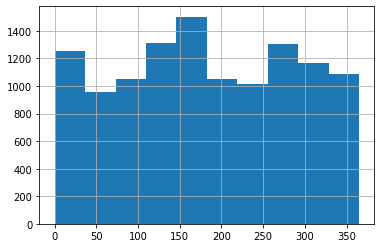

In [ ]:
print(pd.Series(af_svd_lbls).value_counts())
pd.Series(af_svd_lbls).hist()

In [ ]:
# Copy original df
X_af_clustrd_svd = X_train.copy()

# Add predicted cluster labels
X_af_clustrd_svd['af_cluster'] = pd.Series(af_svd_lbls, index = X_af_clustrd_svd.index)
X_af_clustrd_svd

In [ ]:
# Predict labels on test
af_lbls_test_svd = af_svd.predict(X_test_svd)

# Copy test df
X_af_clustrd_test_svd = X_test.copy()

# Add predicted cluster labels to test
X_af_clustrd_test_svd['af_cluster'] = pd.Series(af_lbls_test_svd, index = X_af_clustrd_test_svd.index)
X_af_clustrd_test_svd

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU,af_cluster
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
76524,0.219624,-0.104926,0.356685,-0.533942,0.764879,0.671358,-2.215274,-1.292931,-1.149463,-0.871515,-0.480299,-0.476797,0.590701,1.618095,1.483969,0.729929,0.446445,0.493881,-0.302040,-0.487580,-1.380298,1.955028,1.205296,1.858047,0.543557,0,0,0,0,1,0,0,0,0,0,0,224
59020,-0.598239,-1.058928,-0.901602,0.041772,0.638021,0.170834,0.383609,1.179026,0.652051,0.177313,0.498657,0.370603,-0.259183,-0.924790,-0.549493,0.086476,-0.981342,-0.757870,0.555068,-0.487580,0.307428,-0.204760,-0.070977,-0.017388,1.056534,0,1,0,0,0,1,0,0,1,0,0,128
80187,0.015159,0.705977,1.017609,1.308342,0.172875,1.191508,0.802783,1.494596,1.612938,1.016376,0.716203,1.545468,0.307407,-0.447999,0.147154,-0.959135,-0.553006,-0.987783,-0.730595,0.397473,-1.355026,1.407476,0.258727,0.894678,-1.232113,0,1,0,0,1,0,0,0,1,0,0,304
75026,-1.007171,0.801377,-1.060895,-0.073371,-0.249985,-0.553172,-1.460760,-0.661793,-0.512131,-0.172296,-0.879134,-0.729430,0.024112,-1.401581,-1.015175,-0.154818,0.089498,-0.153477,0.126514,0.397473,-0.401763,-0.387278,-0.772928,-0.838247,0.928404,0,1,0,0,1,0,0,0,0,0,1,105
23161,-0.939016,-0.820428,-0.705421,-1.570226,-1.349422,-2.017841,-0.957750,-1.082552,-1.180344,-1.011359,-1.024164,-1.644521,1.157291,0.346652,0.995624,2.821151,0.732002,2.154366,-1.587703,-10.223163,-6.252588,2.837195,0.599066,1.840946,0.496289,1,1,0,0,1,0,0,0,1,0,0,143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57449,1.787196,1.135278,1.623989,-0.015799,-0.292271,-0.556514,0.802783,-0.766983,0.142147,0.526922,-0.661588,-0.063098,2.290469,-0.447999,0.425242,1.132087,2.659515,2.310037,0.269365,0.397473,0.168123,-0.630634,-0.475131,-0.710558,1.730516,1,1,0,0,0,0,0,0,1,0,0,71
50328,-0.461929,-0.963528,-0.818201,-0.418799,-1.222564,-1.001113,-2.215274,-0.609198,-0.371211,-0.312140,-0.262753,-0.547230,-0.259183,-0.765860,-0.488688,0.890792,-0.481616,0.238421,-0.016337,-0.487580,-0.282830,0.707826,0.003472,0.294234,-1.024846,0,1,0,0,1,0,0,1,0,0,0,209
91121,2.605060,1.564579,2.048389,-0.821798,-0.630560,-1.186895,-0.957750,-0.766983,-0.905392,-0.591828,-0.190238,-0.920540,0.590701,0.505582,0.402649,4.108057,1.945621,3.735020,-5.016138,0.397473,-3.187870,0.738246,0.311905,0.746467,-1.678199,0,1,0,0,1,0,0,0,1,0,0,340


68     97
329    89
50     86
93     81
210    78
       ..
162     1
94      1
223     1
238     1
328     1
Length: 325, dtype: int64


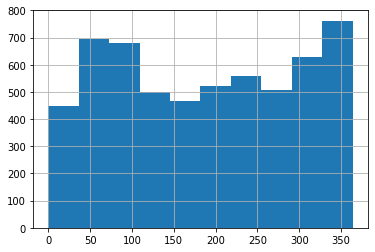

In [ ]:
print(pd.Series(af_lbls_test_svd).value_counts())
pd.Series(af_lbls_test_svd).hist()

## 4.4 Mean-Shift

In [ ]:
%%time
# Data 
#X = X_svd.sample(frac = 0.30)
X = X_svd

# Estimate Bandwidth
bandwidth = estimate_bandwidth(X, quantile=0.3)
print(bandwidth)

# Instantiate
mshift = MeanShift(bandwidth=bandwidth)

# Fit
mshift.fit(X)

# Predict
mshift_lbls = mshift.predict(X)

0.018949694507019197
CPU times: user 2min 41s, sys: 754 ms, total: 2min 42s
Wall time: 2min 44s


In [ ]:
np.unique(mshift.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

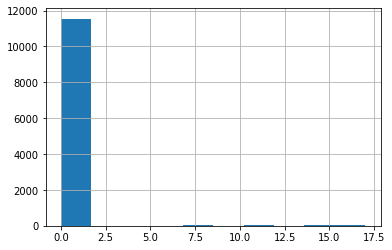

In [ ]:
pd.Series(mshift_lbls).hist()

Create dataset with predicted cluster labels, using mean-shift clustering, as column.

In [ ]:
# Copy original df
X_mshift_clustrd = X_train.copy()

# Add predicted cluster labels
X_mshift_clustrd['mshift_cluster'] = pd.Series(mshift_lbls, index = X_mshift_clustrd.index)
X_mshift_clustrd

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU,mshift_cluster
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
92295,-0.121152,-0.677327,-0.534884,0.675057,-0.334557,0.609659,-0.287071,0.021940,0.086398,0.037469,-0.335269,0.129819,0.590701,-0.765860,-0.328615,-0.717840,0.303666,0.406066,0.269365,0.397473,0.670963,0.677407,-0.113520,0.267633,-0.959147,1,1,0,0,1,0,0,0,0,0,0,0
27002,-0.734550,-1.488229,-1.328842,-0.303656,-0.884276,-0.504762,0.383609,-0.661793,-0.037246,0.177313,-0.661588,-0.391616,-0.542477,-1.242651,-0.873260,0.569066,-0.481616,-0.183087,0.555068,0.397473,1.020671,-0.265600,0.184277,-0.058431,1.004644,1,1,0,0,0,1,0,0,1,0,0,0
55036,-0.530084,-0.915828,-0.638745,0.502343,-0.123127,0.407287,1.305793,0.021940,1.364054,0.946454,-0.190238,1.026835,-1.392361,-0.447999,-0.600703,0.971224,0.874781,0.820047,-0.159189,-0.487580,-0.788855,-0.083082,-0.124155,0.136523,0.721092,1,1,0,0,0,1,0,0,0,0,1,0
56112,-1.347948,2.804782,-0.538730,-0.015799,0.638021,-0.206433,0.467443,-0.504008,0.222636,0.736688,-0.045207,0.586736,0.590701,-1.242651,-0.233623,1.132087,-0.767174,0.142624,0.126514,0.397473,0.786362,-1.299864,2.481569,1.514882,-1.099693,0,1,0,0,1,0,0,0,1,0,0,0
55238,-1.484258,-0.963528,-1.403529,-0.246085,0.595735,-0.198430,0.886618,1.494596,1.414981,0.596844,1.223811,1.401791,1.723880,0.028792,1.563367,-5.431132,-0.553006,-3.936484,0.697920,0.397473,1.316661,-0.630634,-0.241147,-0.242147,-1.519931,0,1,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86270,-0.052997,-0.200326,0.379968,0.041772,-1.180278,-0.659786,0.467443,-0.609198,0.274673,0.317157,-0.697845,-0.160706,1.157291,0.664513,1.932432,-1.119998,-0.909953,-1.210512,-0.444892,-2.257686,-1.329301,-0.235180,-0.060342,-0.447362,-1.253321,1,1,0,0,0,1,0,0,1,0,0,0
55677,-1.484258,-0.295726,-0.446658,-0.821798,2.329463,-0.262715,-2.047604,-1.608500,-2.065887,-0.941437,-0.153980,-1.736672,-0.825772,-0.130139,-0.147697,1.775540,-0.196059,0.909002,0.269365,0.397473,0.168123,-1.664899,0.396989,-0.157846,0.596134,1,1,0,0,1,0,0,1,0,0,0,0
54193,-0.461929,-0.009525,-0.349717,-2.088369,-0.757418,-0.981672,-0.622411,-0.714388,-0.851722,-0.591828,-0.480299,-0.679089,2.007175,3.048468,1.235796,-1.666933,0.303666,-0.889249,-1.159149,0.397473,0.881142,-0.417697,0.843685,0.487756,-0.765276,1,1,0,0,1,0,0,0,0,1,0,0


In [ ]:
# Predict labels on test
mshift_lbls_test = mshift.predict(X_test_svd)

# Copy test df
X_mshift_clustrd_test = X_test.copy()

# Add predicted cluster labels to test
X_mshift_clustrd_test['mshift_cluster'] = pd.Series(mshift_lbls_test, index = X_mshift_clustrd_test.index)
X_mshift_clustrd_test

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU,mshift_cluster
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
76524,0.219624,-0.104926,0.356685,-0.533942,0.764879,0.671358,-2.215274,-1.292931,-1.149463,-0.871515,-0.480299,-0.476797,0.590701,1.618095,1.483969,0.729929,0.446445,0.493881,-0.302040,-0.487580,-1.380298,1.955028,1.205296,1.858047,0.543557,0,0,0,0,1,0,0,0,0,0,0,0
59020,-0.598239,-1.058928,-0.901602,0.041772,0.638021,0.170834,0.383609,1.179026,0.652051,0.177313,0.498657,0.370603,-0.259183,-0.924790,-0.549493,0.086476,-0.981342,-0.757870,0.555068,-0.487580,0.307428,-0.204760,-0.070977,-0.017388,1.056534,0,1,0,0,0,1,0,0,1,0,0,0
80187,0.015159,0.705977,1.017609,1.308342,0.172875,1.191508,0.802783,1.494596,1.612938,1.016376,0.716203,1.545468,0.307407,-0.447999,0.147154,-0.959135,-0.553006,-0.987783,-0.730595,0.397473,-1.355026,1.407476,0.258727,0.894678,-1.232113,0,1,0,0,1,0,0,0,1,0,0,0
75026,-1.007171,0.801377,-1.060895,-0.073371,-0.249985,-0.553172,-1.460760,-0.661793,-0.512131,-0.172296,-0.879134,-0.729430,0.024112,-1.401581,-1.015175,-0.154818,0.089498,-0.153477,0.126514,0.397473,-0.401763,-0.387278,-0.772928,-0.838247,0.928404,0,1,0,0,1,0,0,0,0,0,1,0
23161,-0.939016,-0.820428,-0.705421,-1.570226,-1.349422,-2.017841,-0.957750,-1.082552,-1.180344,-1.011359,-1.024164,-1.644521,1.157291,0.346652,0.995624,2.821151,0.732002,2.154366,-1.587703,-10.223163,-6.252588,2.837195,0.599066,1.840946,0.496289,1,1,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57449,1.787196,1.135278,1.623989,-0.015799,-0.292271,-0.556514,0.802783,-0.766983,0.142147,0.526922,-0.661588,-0.063098,2.290469,-0.447999,0.425242,1.132087,2.659515,2.310037,0.269365,0.397473,0.168123,-0.630634,-0.475131,-0.710558,1.730516,1,1,0,0,0,0,0,0,1,0,0,15
50328,-0.461929,-0.963528,-0.818201,-0.418799,-1.222564,-1.001113,-2.215274,-0.609198,-0.371211,-0.312140,-0.262753,-0.547230,-0.259183,-0.765860,-0.488688,0.890792,-0.481616,0.238421,-0.016337,-0.487580,-0.282830,0.707826,0.003472,0.294234,-1.024846,0,1,0,0,1,0,0,1,0,0,0,0
91121,2.605060,1.564579,2.048389,-0.821798,-0.630560,-1.186895,-0.957750,-0.766983,-0.905392,-0.591828,-0.190238,-0.920540,0.590701,0.505582,0.402649,4.108057,1.945621,3.735020,-5.016138,0.397473,-3.187870,0.738246,0.311905,0.746467,-1.678199,0,1,0,0,1,0,0,0,1,0,0,15


In [ ]:
X_mshift_clustrd_test['mshift_cluster'].value_counts()

0     5612
15      78
1       32
7       26
17      10
5       10
Name: mshift_cluster, dtype: int64

## 4.5 Spectral Clustering

# **Response Variables**

2 (separate) goals:


*   Predict mortality: `HOSPITAL_EXPIRE_FLAG` (binary classification problem)
*   Predict length of stay: `LOS` (continuous regression prediction problem)



In [ ]:
target

,Unnamed: 0,hadm_id,icustay_id,HOSPITAL_EXPIRE_FLAG,LOS
subject_id,,,,,
55440,0,195768,228357,0,4.5761
76908,1,126136,221004,0,0.7582
95798,2,136645,296315,0,3.7626
40708,3,102505,245557,0,3.8734
63311,5,180102,287519,0,1.8490
...,...,...,...,...,...
28043,20880,135417,244530,0,11.6116
87605,20881,191007,216116,0,1.1593
47492,20882,152608,274507,0,1.8830


## Predicting Mortality (Binary)

In this part, the relationship between clusters and mortality (`HOSPITAL_EXPIRE_FLAG==1` if death, zero otherwise) will be explored. A (very simple) Logistic Regression is used to predict and the AUC metric is used to evaluate different clustering algorithms against each other.

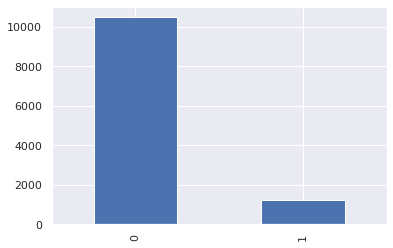

In [ ]:
# Set target variable
y_train_bin, y_test_bin = y_train['HOSPITAL_EXPIRE_FLAG'], y_test['HOSPITAL_EXPIRE_FLAG']
y_train_bin.value_counts().plot(kind="bar")
#y_test_bin.value_counts().plot(kind="bar")

Because of the class imbalance, logistic regression will be run with the `class_weight= 'balanced'` option.

In [614]:
# Set dictionaries to run regressions
train_dict = {'raw': [X_train, X_test], 
              'kmeans': [X_kmeans_clustrd, X_kmeans_clustrd_test], 
              'kmed': [X_kmed_clustrd, X_kmed_clustrd_test], 
              'af': [X_af_clustrd, X_af_clustrd_test], 
              'mshift': [X_mshift_clustrd, X_mshift_clustrd_test]
              } 
train_svd_dict = {'raw': [X_svd, X_test_svd], 
              'kmeans': [X_svd_kmeans_clustrd, X_svd_kmeans_clustrd_test], 
              'kmed': [X_kmed_clustrd_svd, X_svd_kmed_clustrd_test], 
              'af': [X_af_clustrd_svd, X_af_clustrd_test_svd], 
              'mshift': [X_mshift_clustrd, X_mshift_clustrd_test]
              }   

### Comparing Clustering Methods over 'raw' data (non-SVD'd)

NB: `raw` does not contain predicted clustering labels. Other datasets contain predicted labels using the designated clustering method. Idea is here to compare the addition of predicted cluster labels on metric scores

In [604]:
#Dictionaries to store scores
auc_dict = {'raw': [], 'kmeans': [], 'kmed': [], 'af': [], 'mshift': [] } 

for method in train_dict.keys():
  # Model
  logit = LogisticRegression(class_weight= 'balanced', max_iter = 5000)
  logit.fit(train_dict[method][0], y_train_bin)

  # Predictions, prob
  p_pred = logit.predict_proba(train_dict[method][1])
  p_pred = p_pred[:,1]

  # Predictions, point
  y_test_pred = logit.predict(train_dict[method][1])

  # Assesment
  fpr, tpr, thresh = metrics.roc_curve(y_test_bin, p_pred)
  auc = metrics.auc(fpr, tpr)
  auc_dict[method].append(auc)

#Print results
print(sorted(auc_dict.items(), key=lambda x: x[1], reverse=True))

[('kmed', [0.790752678614187]), ('kmeans', [0.7903736985047857]), ('raw', [0.7901204708862312]), ('af', [0.7896987693826792]), ('mshift', [0.7883347855162071])]


Conclusion: $k$-medioids (on the non-SVD'd data) does the best of the clustering algorithms in predicting mortality as it gets the highest AUC score. This might be because $k$-medioids is less sensitive to outliers compared to $k$-means (medians vs means)

### Comparing Clustering Methods over SVD'd data 

NB: `raw` does not contain predicted clustering labels. Other datasets contain predicted labels using the designated clustering method. Idea is here to compare the addition of predicted cluster labels on metric scores

In [591]:
#Dictionaries to store scores
auc_svd_dict = {'raw': [], 'kmeans': [], 'kmed': [], 'af': [], 'mshift': [] } 

for method in train_svd_dict.keys():
  # Model
  logit = LogisticRegression(class_weight= 'balanced', max_iter = 5000)
  logit.fit(train_svd_dict[method][0], y_train_bin)

  # Predictions, prob
  p_pred = logit.predict_proba(train_svd_dict[method][1])
  p_pred = p_pred[:,1]

  # Predictions, point
  y_test_pred = logit.predict(train_svd_dict[method][1])

  # Assesment
  fpr, tpr, thresh = metrics.roc_curve(y_test_bin, p_pred)
  auc = metrics.auc(fpr, tpr)
  auc_svd_dict[method].append(auc)

#Print results
print(sorted(auc_svd_dict.items(), key=lambda x: x[1], reverse=True))

[('kmeans', [0.7886569186091981]), ('mshift', [0.7883347855162071]), ('kmed', [0.787047975781104]), ('af', [0.776437221772614]), ('raw', [0.2690679535453072])]


Conclusion: $k$-medioids also does the best on the SVD'd data. Affinity Propagation does next-best so it would have been nice if it had worked on the raw data to compare those results. Again, $k$-medioids is less sensitive to outliers compared to $k$-means.

##  Predicting Length of Stay (Continuous)

In this part, the relationship between clusters and lenght of stay (`LOS`$\in\mathbb{R}$) will be explored. A (very simple) Linear Regression is used to predict and the Root-Mean-Squared-Error (RMSE) metric is used to evaluate different clustering algorithms against each other.

In [ ]:
# Set target variable
y_train_reg, y_test_reg = y_train['LOS'], y_test['LOS']

In [ ]:
print("Train:")
print(y_train_reg.describe())
print("\n")
print("Test:")
print(y_test_reg.describe())

Train:
count    11708.000000
mean         3.671716
std          5.182868
min          0.112000
25%          1.176275
50%          2.016750
75%          3.857050
max        101.739000
Name: LOS, dtype: float64


Test:
count    5768.000000
mean        3.563502
std         4.845117
min         0.256600
25%         1.175525
50%         2.003550
75%         3.809750
max        63.453300
Name: LOS, dtype: float64


### Comparing Clustering Methods over 'raw' data (non-SVD'd)

NB: `raw` does not contain predicted clustering labels. Other datasets contain predicted labels using the designated clustering method. Idea is here to compare the addition of predicted cluster labels on metric scores

In [615]:
#Dictionaries to store scores
rmse_dict = {'raw': [], 'kmeans': [], 'kmed': [], 'af': [], 'mshift': [] } 

for method in train_dict.keys():
  # Model
  reg = LinearRegression()
  reg.fit(train_dict[method][0], y_train_reg)
  y_hat = reg.predict(train_dict[method][1])

  # Assesment
  rmse = metrics.mean_squared_error(y_true = y_test_reg, y_pred = y_hat, squared=False)
  rmse_dict[method].append(rmse)

#Print results
print(sorted(rmse_dict.items(), key=lambda x: x[1], reverse=False))

[('kmeans', [4.594636887408864]), ('kmed', [4.594804442715152]), ('raw', [4.594947907534065]), ('mshift', [4.595134204225295]), ('af', [4.595289063690339])]


Conclusion: For prediction of continuous variable `LOS` (Length of Stay) $k$-means actually does the best amongst the utilized clustering methods.


### Comparing Clustering Methods over SVD'd data 

NB: `raw` does not contain predicted clustering labels. Other datasets contain predicted labels using the designated clustering method. Idea is here to compare the addition of predicted cluster labels on metric scores

In [593]:
#Dictionaries to store scores
rmse_svd_dict = {'raw': [], 'kmeans': [], 'kmed': [], 'af': [], 'mshift': [] } 

for method in train_svd_dict.keys():
  # Model
  reg = LinearRegression()
  reg.fit(train_svd_dict[method][0], y_train_reg)
  y_hat = reg.predict(train_svd_dict[method][1])

  # Assesment
  rmse = metrics.mean_squared_error(y_true = y_test_reg, y_pred = y_hat, squared=False)
  rmse_svd_dict[method].append(rmse)

#Print results
print(sorted(rmse_svd_dict.items(), key=lambda x: x[1], reverse=False))

[('kmed', [4.593688716354437]), ('af', [4.595103948967394]), ('mshift', [4.595134204225295]), ('kmeans', [4.596063611412447]), ('raw', [5.36617373715455])]


Conclusion: On the SVD'd data $k$-medioids does the best amongst the clustering methods – although Affinity Propagation and Mean Shift also do well here. 